# Assignment 1
## Getting started with SED fitting & error estimation


This assignment is split into 3 sections, roughly corresponding to the contents of each of the 3 weeks in the Error Estimation module. 

The SETUP section is designed to be done first, to familarize yourself with the data and the details of SED fitting. Section 1 is shorter to account for this. You should be able to finish Section 1 after January 26th, Section 2 after February 2nd, and Section 3 after February 9th. You can work on this assignment during the lab hours, as well as in your own time - and feel free to ask the instructors questions!

All assignments are presented as Jupyter notebooks. You will fork the repository to have your own access to all files. You can edit this notebook directly with your answers and push your changes to GitHub. Feel free to write any commonly used functions in a separate module and import them here if you like.

# Section 0
## Setup

First, we need to set up the SED fitting project, install Prospector, and make sure we can run Prospector. This section is written assuming that you are using a Unix-based system (including MacOS). If you are using Windows, consider installing and using [Windows Subsystem for Linux, or WSL](https://learn.microsoft.com/en-us/training/modules/wsl-introduction/).

1. Download the data from [here](https://irfu.cea.fr/Pisp/yu-yen.chang/sw.html) (both the input and output catalog). <br>
   The data comes from [Chang et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015ApJS..219....8C/abstract), who used MAGPHYS (another SED fitting code) to fit the photometry stored in the input file and obtain stellar masses / ages / etc. stored in the output file. <br>
   > Be careful of where you store these files. If you store them in a random place in this repository, they will get pushed to Git alongside your changes. The files are heavy, which will cause problems downstream. We suggest placing your files in `projects/sed-fitting/data` folder (for Chang catalogs) and `projects/sed-fitting/output` folder (for your own Prospector output files). These folders are added in the `.gitignore` file in the root, and so anything in these folders will be ignored by Git.
   
2. Install [Prospector](https://github.com/bd-j/prospector)
   > We found this easiest to do using the [conda script](https://github.com/bd-j/prospector/blob/main/conda_install.sh) provided: download the script somewhere on your PC and run `bash conda_install.sh`. Again, best not to do this inside the Git repository as the bash script will download several large libraries. If you are feeling brave, you can try doing it from this repository, but first make sure to add the libraries to `.gitignore`. <br>
   > Make sure to follow the instructions from `conda_install.sh`: add SPS_HOME to your `~/.bashrc` file as your terminal says.<br>
   > This bash script will create a new conda environment, `prospector`, which you can run using `conda activate prospector`.
    <br><br>

3. Fix a Prospector + NumPy >= 1.20 issue (you might not need this)<br>
   Run the following cell:

In [1]:
import numpy as np
print(np.__version__)

1.26.3


If the version is greater than 1.20.0, you will need to fix a library in Prospector to make it compatible with a later NumPy. There is a file `write_results.py` in the project library. Copy it to your Prospector installation location within your conda environment, it should be something like `/home/[username]/[your conda installation]/envs/prospector/lib/[your python version]/site-packages/prospect/io`

4. Install any other Python libraries<br>Since we have made a new environment, it will only have prospector and its dependancies installed. We still need to install other useful Python libraries in the new environment. 
   > We listed the libraries you will need in `requirements.txt`.<br>
   > First, run `conda activate prospector` to make sure you are using the new environment. <br>
   > Then, you can install all required libraries simply using `pip install -r requirements.txt`


## Test Prospector

We have provided a notebook, Prospector Example, that gives step-by-step instructions for loading in the photometric data for one galaxy and running Prospector to get a simple fit to that galaxy's SED. If you have any questions, you can either ask us, or consult the [Prospector documentation](https://prospect.readthedocs.io/en/latest/) that has explanations of all the different parameters, models, and use cases.

#### Step 1
Open the example notebook and run it completely without changing anything. <br> (This is to make sure everything is installed right)

#### Step 2
Try to change some fitting parameters: you can try a different galaxy, play around with different priors, try a different star formation model, or a different sampling technique.

What did you try? What was different between the fits?


####  <font color='red'> My answer
<font color='red'>
When changing galaxy, the sed changed and so did the fit since it's a different object. Depending on the object, a different star formation model can improve the goodness of the fit or make it worst since it depends whether or not the star formation model is appropriate to describe star formation occuring in the system. Depending on which parameters are set free (being fitted), degeneracies can happen which will affect how well some parameters can be constrained.



#### Step 3
Try running Prospector through a command line.

Re-running a notebook each time is impractical, so to fit several galaxies, it's easier to write everything as a Python script we can run from the command line. We wrote a Python script for you, `assignment_params.py`. 

It has a few command line arguments. You can see the meaning of the different arguments by running

     python assignment_params.py --help

Try running this line in your command line to ensure that Prospector works fine and produce a fit for a test galaxy.

> Note: if you stored your data files elsewhere, you will need to change the path to the input catalog on Line 200.

#### Step 4

Here we load in the data, select one random set of parameters $\vec{\theta}$, and the optimized set of parameters $\vec{\theta}_{max}$. We also generate an SED from these two models, and a full spectroscopic model.

In [2]:
import prospect.io.read_results as reader
import matplotlib.pyplot as plt

Loading in data:

In [3]:
file_name = '../output/test_24Feb08-16.10_result.h5' #### Change this to your filename!
res, obs, model = reader.results_from(file_name)
results_type = "emcee" # | "dynesty"
sps = reader.get_sps(res)

Selecting a random and the best models:

In [4]:
# To draw a random chain
randint = np.random.randint

# Selecting a random (not best) parameter vector from MCMC
if results_type == "emcee":
    nwalkers, niter = 2, 2
    theta = res['chain'][randint(nwalkers), randint(niter)]
else:
    theta = res["chain"][randint(len(res["chain"]))]

# Index of the best chain / parameter vector
imax = np.argmax(res['lnprobability'])

# Selecting the best parameter vector
if results_type == "emcee":
    i, j = np.unravel_index(imax, res['lnprobability'].shape)
    theta_max = res['chain'][i, j, :].copy()
    thin = 5
else:
    theta_max = res["chain"][imax, :]
    thin = 1

# Can also get theta_max from res['bestfit']['parameter']

Getting x-values: the central wavelengths of our filters, and changing them to restframe

In [5]:
# cosmological redshifting
a = 1.0 + model.params.get('zred', 0.0) 

# photometric effective wavelengths
wphot = obs["phot_wave"]

# spectroscopic wavelengths
# *restframe* spectral wavelengths, since obs["wavelength"] is None
wspec = sps.wavelengths
wspec *= a #redshift them

# Find bounds 
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()*10

Create the SEDs for the random and the best fit models. The SED photometry is stored in `mspec` (first returned value) and the full spectrum is in `mphot` (second returned value).

In [6]:
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

mphot_map

array([1.13820831e-08, 2.37772642e-08, 3.54684640e-08, 4.10744246e-08,
       4.87048178e-08, 3.91429573e-08, 2.70488725e-08, 1.92090538e-07,
       2.28053982e-07])

## Note:

Can also get mspec_map by doing res['bestfit']['spectrum']

Can also get mphot_map by doing res['bestfit']['photometry'] 

Plot the fit and the model:

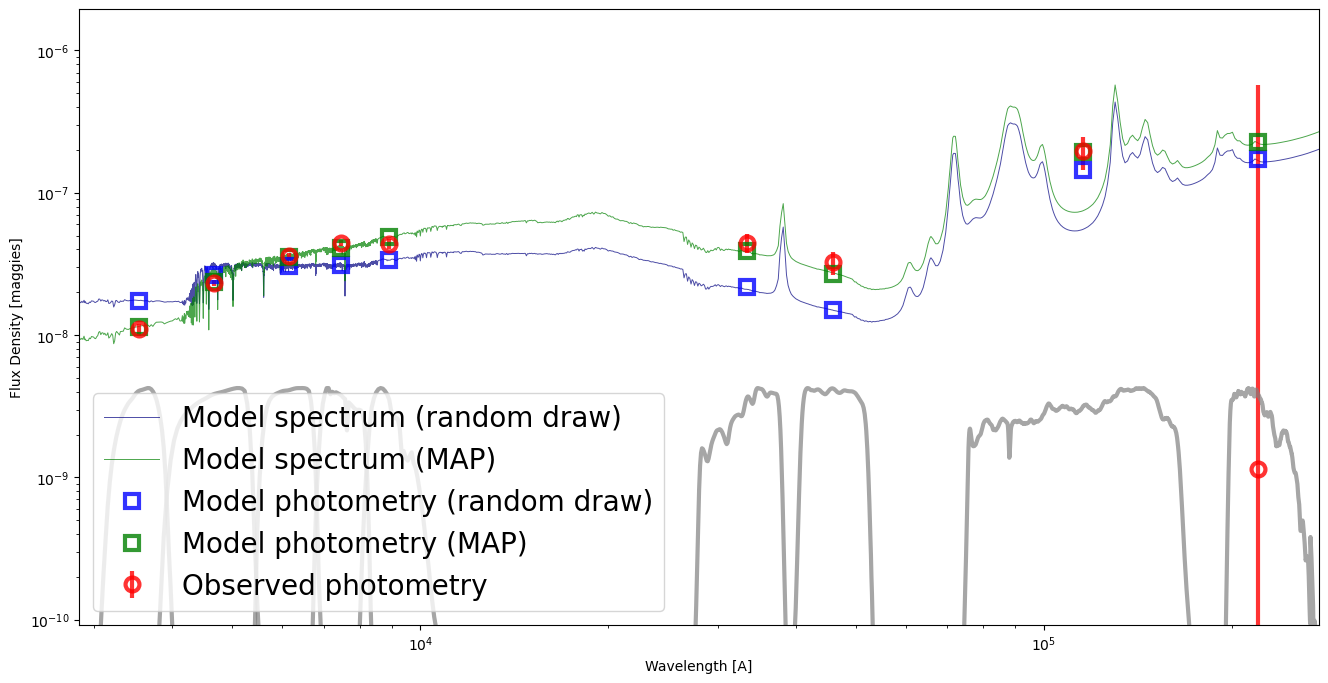

In [7]:
# Make plot of data and model
plt.figure(figsize=(16,8))

plt.loglog(wspec, mspec, label='Model spectrum (random draw)',
       lw=0.7, color='navy', alpha=0.7)
plt.loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
plt.errorbar(wphot, mphot, label='Model photometry (random draw)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
plt.errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin/10,ymax])
plt.legend(loc='best', fontsize=20)

# plt.ylim(1e-9, 1e-6)

> Note: if you want to make these plots several times for different galaxies / fits, it may be useful to save this code as a separate Python file, e.g. `plotting.py`. You can then import these functions in this notebook or elsewhere without re-defining them.

#### Step 5

The code below loads in the table containing the photometry of all galaxies as a [Pandas DataFrame](https://pandas.pydata.org/). Select a sample of galaxies to run Prospector on. 

In [8]:
from astropy.table import Table
from astropy.io import fits
with fits.open('../data/sw_input.fits') as f:
    df = Table(f[1].data).to_pandas()
    f.close()

df.iloc[33]

id                              65
ra                         3.19715
dec                       1.261998
redshift                  0.153977
PLATE                         1491
MJD                          52996
FIBERID                        411
designation    J001247.30+011543.3
flux0_u                   0.000036
flux0_u_e                 0.000003
flux0_g                   0.000078
flux0_g_e                 0.000001
flux0_r                   0.000123
flux0_r_e                 0.000002
flux0_i                   0.000156
flux0_i_e                 0.000003
flux0_z                   0.000154
flux0_z_e                 0.000012
flux0_w1                  0.000119
flux0_w1_e                0.000006
flux0_w2                  0.000087
flux0_w2_e                0.000012
flux0_w3                  0.000521
flux0_w3_e                0.000169
flux0_w4                  0.004161
flux0_w4_e                   9.999
flux_u                     0.00004
flux_u_e                  0.000004
flux_g              

In [9]:
#Choosing Abell 1835 because it's really cool.
diff=np.sqrt((df['ra']-210.259583)**2+(df['dec']-2.880000)**2)
np.where(diff==np.min(diff))

(array([83613]),)

In [10]:
# Most redshifted
np.where(df['redshift']==np.max(df['redshift']))

(array([778899]),)

In [11]:
# Least redshifted
np.where(df['redshift']==np.min(df['redshift']))

(array([845803]),)

**Optional:** how did you choose your set of galaxies? It's okay if they are all random, but if you want, you can try to choose a sample you find interesting.

<font color='red'> 
I chose Abell 1835 because I have work on that object. I also chose galaxy 33 because it's the initial one and I chose the most redshifted and the least redshifted galaxies.

In [12]:
# Space to select a sample of N galaxies, answer the question, or do something else. 
# If you are sampling randomly, you can use df.sample()!
sample=[33,83613,778899,845803]

Don't forget to save your sample or at least note down the id's you used!

#### Step 6

Run Prospector on your chosen sample. Feel free to use the default code we provided, or try your own fitting / modelling parameters.

> Hint: you can use Jupyter to run something from the command line using `!`. This allows you to pass variables from your Jupyter environment as arguments in curly braces `{...}`. For example, you could run:

    ! python assignment_params.py --objid={your_index} --optimize --emcee 

> If you are using Python without Jupyter, you can't use `!`, but you can use [subprocess.run()](https://docs.python.org/3/library/subprocess.html#subprocess.run) function.

In [13]:
! python assignment_params.py --objid=83613 --optimize --emcee 

#### Step 7

The photometry of the galaxy changes based on how far away it is: galaxies further away are fainter, and their SED shifts more towards red wavelengths. This is one of the challenges of SED fitting: it's hard to break the degeneracy between galaxies that are red because they are intrinsically red (older stars), and galaxies that are red because they are far away. 

By default, we give Prospector a *known* spectroscopic redshift for each galaxy. This means that it is not fitting one of the important degenarate parameters.

However, obtaining a spectroscopic redshift is difficult, as it requires measuring a galaxy spectrum - simple photometry is way easier. The galaxies we used in this project all have spectroscopy, but there are millions of galaxies that do not. For those objects, we need to fit the SED *and* redshift simultaneously.

Let's imagine that we don't know the redshift of our objects. For your sample, re-run the Prospector fits by setting redshift as one of the free parameters. You can change the redshift from fixed to free by using `--var-redshift` argument when calling `assignment_params.py`. 

In [14]:
from tqdm.notebook import tqdm
for idx, row in tqdm(sample.iterrows(), total=len(sample)):
    outname = f'gal{idx}_emcee_varz'
    # Uncomment this to run
    # ! python assignment_params.py --objid={idx} --optimize --emcee --outfile={outname} --var_redshift

# Section 1

#### Step 1: Goodness-of-Fit

Choose one of your galaxies, load in the data, and plot the original data and the best fit with error bars.

Compute the goodness-of-fit ($\chi^2$) of your fit. 

> Note: Prospector assumes the magnitudes are independent so you can to, but we'll come back to this later

In [15]:
import prospect.io.read_results as reader
import matplotlib.pyplot as plt

In [16]:
# Space to work

file_name = '../output/Galaxy33_fixedredshift_24Feb15-15.56_result.h5' #### Change this to your filename!
res, obs, model = reader.results_from(file_name)
results_type = "emcee" # | "dynesty"
sps = reader.get_sps(res)
print(model)

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=30)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.15397674] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [0] 


In [17]:
chains=res['chain']
print(chains.shape)
flatten_chains=chains.reshape(64*512,5)

(64, 512, 5)


In [18]:
photo_results=[]
for i in range(len(flatten_chains)):
    #if(i%512==0):
        #print(i)
    a,b,c=model.mean_model(flatten_chains[i], obs, sps=sps)
    photo_results.append(b)

In [19]:
photo_results=np.array(photo_results)
imax = np.argmax(res['lnprobability'])
if results_type == "emcee":
    i, j = np.unravel_index(imax, res['lnprobability'].shape)
    theta_max = res['chain'][i, j, :].copy()
    thin = 5
else:
    theta_max = res["chain"][imax, :]
    thin = 1

mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)
photo_max=np.quantile(photo_results,0.841,axis=0)
photo_min=np.quantile(photo_results,0.159,axis=0)

#plt.hist(photo_results.T[1])
#print(len(photo_results.T[1]))
#print(mphot_map)
#print(photo_min,np.quantile(photo_results,0.159,axis=0),mphot_map)

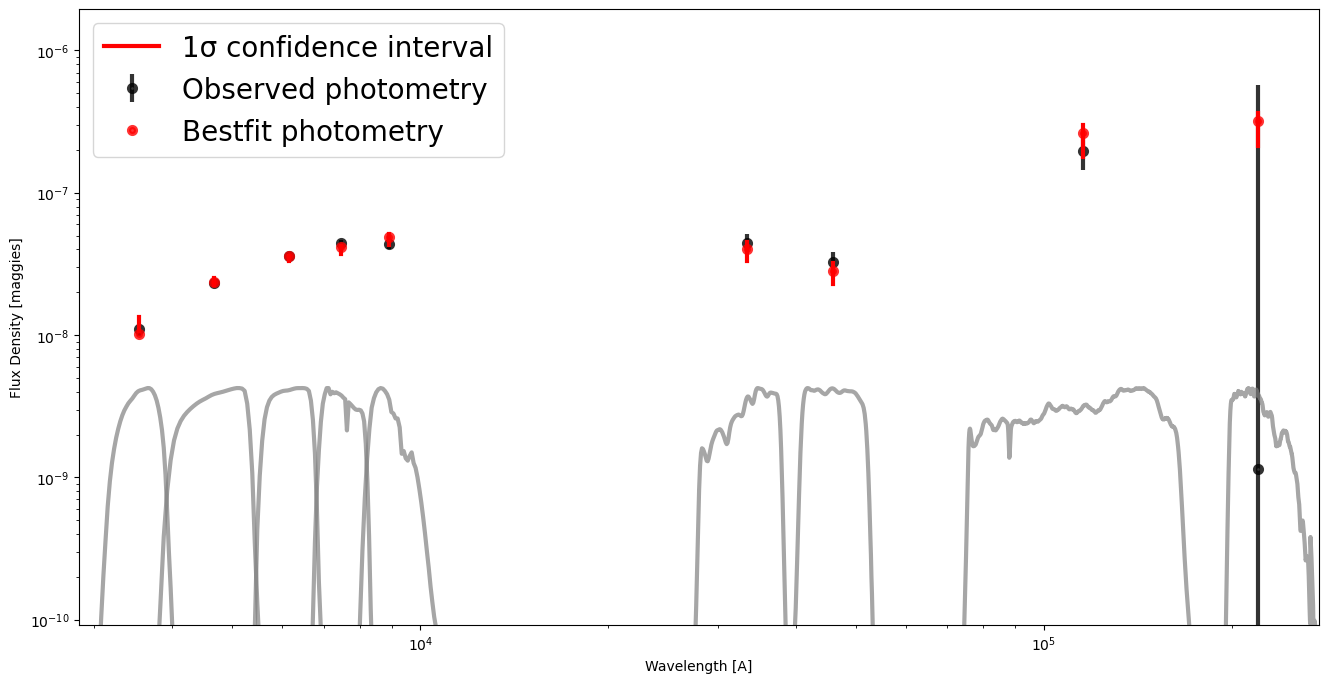

In [20]:

# Index of the best chain / parameter vector
imax = np.argmax(res['lnprobability'])

# Selecting the best parameter vector
if results_type == "emcee":
    i, j = np.unravel_index(imax, res['lnprobability'].shape)
    theta_max = res['chain'][i, j, :].copy()
    thin = 5
else:
    theta_max = res["chain"][imax, :]
    thin = 1

# cosmological redshifting
a = 1.0 + model.params.get('zred', 0.0) 

# photometric effective wavelengths
wphot = obs["phot_wave"]

# spectroscopic wavelengths
# *restframe* spectral wavelengths, since obs["wavelength"] is None
wspec = sps.wavelengths
wspec *= a #redshift them

# Find bounds 
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()*10

#mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
#mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

# Make plot of data and model
plt.figure(figsize=(16,8))


plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='black', 
         fmt='.', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='black', 
         markeredgewidth=3)

plt.errorbar(wphot, mphot_map,label='Bestfit photometry', color='red', fmt='.', markersize=10, ls='', lw=3, alpha=0.8, markeredgewidth=3)

# For one of the bestfit data point, it does not lie within the 1σ confidence interval.
#Therefore, I had to use a different way to plot the errrorbars since plt.errorbar does not want to plot errorbars which do not overlap with the data point.
for i in range(len(wphot)):
    if i==0:
        plt.plot([wphot[i],wphot[i]],[photo_min[i],photo_max[i]],color='red',lw=3,label='1σ confidence interval',zorder=10)
    else:
        plt.plot([wphot[i],wphot[i]],[photo_min[i],photo_max[i]],color='red',lw=3,zorder=10)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin/10,ymax])
plt.legend(loc='best', fontsize=20)


## <font color='red'> Note 1
<font color='red'>
For one of the bestfit data point, it does not lie within the 1σ confidence interval. Therefore, I had to use a different way to plot the errrorbars since plt.errorbar does not want to plot errorbars which do not overlap with the data point.

## <font color='red'> Note 2
<font color='red'>
The bestfit photometry for the 2nd point does not lie in the 1σ confidence interval. This is not problematic as all the photometry points are being fitted together so you can get an overall better fit even if one point is not in its 1σ confidence interval for all the chains.

In [21]:
obs_photo=obs['maggies']
err_obs=obs['maggies_unc']
model_photo=res['bestfit']['photometry']

<font color='red'>

$$ \chi^2 = \sum_i (\frac{y_i - x_i}{\delta y_i})^2 $$

where we are summing over the i photometric points, y is the observed magnitude, δy is the uncertainty on the observed magnitude and x is the modelled magnitude.

In [22]:
χ2=np.sum(((obs_photo - model_photo) / err_obs)**2)
print('χ2= ',χ2)

χ2=  7.4965814188931645


Is your goodness-of-fit reasonable? Why / why not?

<font color='red'>
To test the goodness-of-fit we want to look at the reduced $\chi^2$ which is $\chi^2/\nu$ where $\nu$ is the numbers of degrees of freedom which is the number of observations minus the number of fitted parameters. We have 9 data points and 5 parameters so $\nu=4$.

In [23]:
red_χ2=χ2/4
red_χ2

1.8741453547232911

<font color='red'>
Our goodness-of-fit is reasonable. Since $\chi_{\nu}^2 > 1$, this means that the fit does not fully describe the data or that the uncertainties in the measured photometries are underestimated. However, since our $\chi_{\nu}^2$ is close to 1 and not much greater than 1, it means that the bestfit model fits our data fairly well.

#### Step 2: Fit results

What are the best fit, mean, and $1\sigma$, $2\sigma$, $3\sigma$ confidence intervals for each of the constrained parameters?

<font color='red'> Answers:

In [24]:
# Space to work

# Get best fit parameters

free_params_names=res['theta_labels']
bestfit=res['bestfit']
bestfit_free=bestfit['parameter']
print('The best fit parameters are:')
for i in range(len(free_params_names)):
    print('{} {:.2e}'.format(free_params_names[i],bestfit_free[i]))
#print(mean0)

The best fit parameters are:
mass 1.01e+10
logzsol -3.13e-01
dust2 4.97e-01
tage 1.62e+00
tau 4.95e-01


In [25]:
chains=res['chain']
flatten_chains=chains.reshape(64*512,5)
mean0=np.mean(flatten_chains,axis=0)

print('The mean of the constrained parameters is:')
for i in range(len(mean0)):
    print('{} {:.2e}'.format(free_params_names[i],mean0[i]))

The mean of the constrained parameters is:
mass 1.40e+10
logzsol -2.89e-01
dust2 3.69e-01
tage 6.80e+00
tau 1.47e+01


In [26]:
median0=np.median(flatten_chains,axis=0)

print('The median of the constrained parameters is:')
for i in range(len(median0)):
    print('{} {:.2e}'.format(free_params_names[i],median0[i]))

The median of the constrained parameters is:
mass 1.49e+10
logzsol -2.31e-01
dust2 3.68e-01
tage 6.85e+00
tau 1.40e+01


In [27]:
σ1_m=np.quantile(flatten_chains,0.159,axis=0)
σ1_p=np.quantile(flatten_chains,0.841,axis=0)
σ2_m=np.quantile(flatten_chains,0.023,axis=0)
σ2_p=np.quantile(flatten_chains,0.977,axis=0)
σ3_m=np.quantile(flatten_chains,0.2/100,axis=0)
σ3_p=np.quantile(flatten_chains,99.8/100,axis=0)

print('1σ interval:')
for i in range(len(free_params_names)):
    print('{}: {:.2e} to {:.2e}'.format(free_params_names[i],σ1_m[i],σ1_p[i]))
print()
print('2σ interval:')
for i in range(len(free_params_names)):
    print('{}: {:.2e} to {:.2e}'.format(free_params_names[i],σ2_m[i],σ2_p[i]))
print()
print('3σ interval:')
for i in range(len(free_params_names)):
    print('{}: {:.2e} to {:.2e}'.format(free_params_names[i],σ3_m[i],σ3_p[i]))

1σ interval:
mass: 7.10e+09 to 1.97e+10
logzsol: -5.63e-01 to -1.34e-02
dust2: 2.86e-01 to 4.51e-01
tage: 2.66e+00 to 1.05e+01
tau: 6.37e+00 to 2.37e+01

2σ interval:
mass: 2.28e+09 to 2.38e+10
logzsol: -1.04e+00 to 1.46e-01
dust2: 2.01e-01 to 5.33e-01
tage: 7.01e-01 to 1.32e+01
tau: 2.51e+00 to 2.88e+01

3σ interval:
mass: 1.74e+09 to 2.79e+10
logzsol: -1.63e+00 to 1.82e-01
dust2: 1.39e-01 to 6.15e-01
tage: 2.63e-01 to 1.37e+01
tau: 1.00e-01 to 2.99e+01


<font color='red'> End of answers for now

Are your results consistent with the fit from Chang et al.? (You can look up their values in the [output catalog](https://irfu.cea.fr/Pisp/yu-yen.chang/sw.html)). 

How similar do we expect them to be?

In [68]:
# Space to work
#from astropy.io import fits

#hdul = fits.open('../data/sw_output.fits')

In [28]:
from astropy.table import Table

catalog=Table.read('../data/sw_output.fits')

data33=catalog[33]

print(data33)

 id lmass2_5_all lmass16_all lmass50_all lmass84_all lmass97_5_all lsfr2_5_all lsfr16_all lsfr50_all lsfr84_all lsfr97_5_all lssfr2_5_all lssfr16_all lssfr50_all lssfr84_all lssfr97_5_all ldust2_5_all ldust16_all ldust50_all ldust84_all ldust97_5_all mu2_5_all mu16_all mu50_all mu84_all mu97_5_all tau_v2_5_all tau_v16_all tau_v50_all tau_v84_all tau_v97_5_all    vmax     lrest_u     lrest_g      lrest_r      lrest_i      lrest_z      lrest_w1     lrest_w2     lrest_w3      lrest_w4   flag_r flag_w flag_w1 flag_w2 flag_w3 flag_w4 flag_chi2 flag
--- ------------ ----------- ----------- ----------- ------------- ----------- ---------- ---------- ---------- ------------ ------------ ----------- ----------- ----------- ------------- ------------ ----------- ----------- ----------- ------------- --------- -------- -------- -------- ---------- ------------ ----------- ----------- ----------- ------------- --------- ----------- ------------ ------------ ------------ ------------ ------------ -

<font color='red'> Answers:

In [29]:
#data=hdul[1].data
#data33=data[33]

print('Cheng stellar mass:')
print('Median: {:.2e}'.format(10**data33[3]))
print('1σ confidence: {:.2e} to {:.2e}'.format(10**data33[2],10**data33[4]))
print('2σ confidence: {:.2e} to {:.2e}'.format(10**data33[1],10**data33[5]))

Cheng stellar mass:
Median: 5.75e+09
1σ confidence: 4.90e+09 to 7.24e+09
2σ confidence: 4.27e+09 to 9.12e+09


<font color='red'>
My 1σ confidence interval from the fit is between $7.10\times10^9 M_{\odot}$ and $1.97\times10^{10} M_{\odot}$. Chang et al. has a 1σ confidence interval of $4.90\times10^9 M_{\odot}$ and $7.24\times10^{9} M_{\odot}$. My result is consistent with the Chang et al. fit within 1σ.

Based on the plot from Step 1, my modelled photometric points were closed to the observed ones so my results look reasonable. Since Chang et al. wrote a paper about their galaxy fits, I expect them to have gotten good fits so I expect our values to be similar.

#### Step 3: Comparing samples

Check the probability distribution of a single parameter (e.g., stellar mass) for a single galaxy and compare to the result from Chang et al. How different do you expect them to be? what does this tell you about the models you and Chang et al are fitting? You can try for a few different galaxies if you like to see if your conclusions are the same

[0.25303544 0.11678559 0.16544625 0.22870511 0.26276757 0.31872733
 0.33332553 0.36982103 0.47200842 0.52310211 0.72990992 0.56932974
 0.80533395 0.84426248 0.91482044 1.18732014 1.28464147 1.3089718
 1.64473036 1.71042225 2.21892617 2.17513157 2.03401565 2.2359574
 2.38680545 3.22376883 3.12401447 3.25053219 2.85638083 3.35758565
 2.76879164 2.72256402 2.8320505  2.61064449 2.11430575]


<BarContainer object of 1 artists>

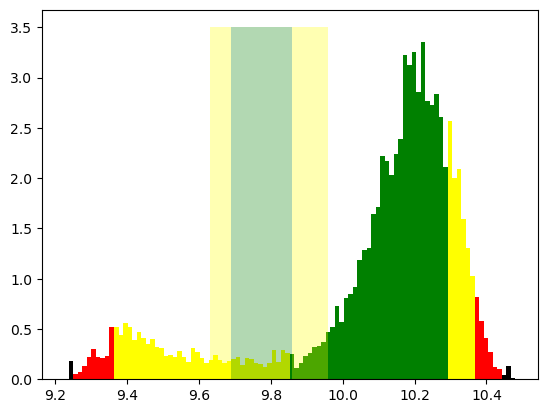

In [30]:
vals,bins,_=plt.hist(np.log10(flatten_chains[:,0]),bins=100,density=True,color='black')
cond1=(bins[1:]<=np.log10(σ1_p[0]))&(bins[:-1]>=np.log10(σ1_m[0]))
print(vals[cond1])
new_vals=np.copy(vals)
new_vals[cond1==0]=0

plt.bar(bins[:-1],new_vals,width=bins[2]-bins[1],color='green',align='edge')

cond2=(bins[1:]<=np.log10(σ2_p[0]))&(bins[:-1]>=np.log10(σ2_m[0]))&(cond1==0)
new_vals=np.copy(vals)
new_vals[cond2==0]=0
plt.bar(bins[:-1],new_vals,width=bins[2]-bins[1],color='yellow',align='edge')

cond3=(bins[1:]<=np.log10(σ3_p[0]))&(bins[:-1]>=np.log10(σ3_m[0]))&(cond2==0)&(cond1==0)
new_vals=np.copy(vals)
new_vals[cond3==0]=0
plt.bar(bins[:-1],new_vals,width=bins[2]-bins[1],color='red',align='edge')

plt.bar(data33[2],3.5,width=data33[4]-data33[2],align='edge',color='Green',alpha=0.3)
plt.bar(data33[1],3.5,width=data33[2]-data33[1],align='edge',color='Yellow',alpha=0.3)
plt.bar(data33[4],3.5,width=data33[5]-data33[4],align='edge',color='Yellow',alpha=0.3)

<font color='red'>

Notes of plot: The green, yellow, and red parts of the histogram shows the 1σ, 2σ and 3σ confidence intervals for our probability distribution. The shaded green and yellow areas show the 1σ, 2σ confidence intervals from Chang et al.

Our probability distribution function is much wider than Chang et al. which is expected from our uncertainties being much larger than the ones from Chang et al. This tells me that the model that Chang et al. are using is better at constraining galaxy stellar masses than our model. This is expected since Chang et al. wrote a paper (did a lot of research) and I used one of the basic fits offered by prospector.

#### Step 4: Redshift

How did allowing the redshift as a free parameter change the results? Did you get the same mass? Is the redshift correct?

In [31]:
# Space to work

file_name_free = '../output/Galaxy33_freeredshift_24Feb15-16.04_result.h5' #### Change this to your filename!
res_free, obs_free, model_free = reader.results_from(file_name_free)
results_type = "emcee" # | "dynesty"
sps_free = reader.get_sps(res_free)

In [32]:
chains_free=res_free['chain']
flatten_chains_free=chains_free.reshape(64*512,6)
chains_free.shape

(64, 512, 6)

In [33]:
photo_results_free=[]
for i in range(len(flatten_chains_free)):
    a,b,c=model_free.mean_model(flatten_chains_free[i], obs_free, sps=sps_free)
    photo_results_free.append(b)

In [34]:
photo_results_free=np.array(photo_results_free)
imax_free = np.argmax(res_free['lnprobability'])
if results_type == "emcee":
    i, j = np.unravel_index(imax_free, res_free['lnprobability'].shape)
    theta_max_free = res_free['chain'][i, j, :].copy()
    thin = 5
else:
    theta_max_free = res_free["chain"][imax_free, :]
    thin = 1

mspec_map_free, mphot_map_free, _ = model_free.mean_model(theta_max_free, obs_free, sps=sps_free)
photo_max_free=np.quantile(photo_results_free,0.841,axis=0)
photo_min_free=np.quantile(photo_results_free,0.159,axis=0)

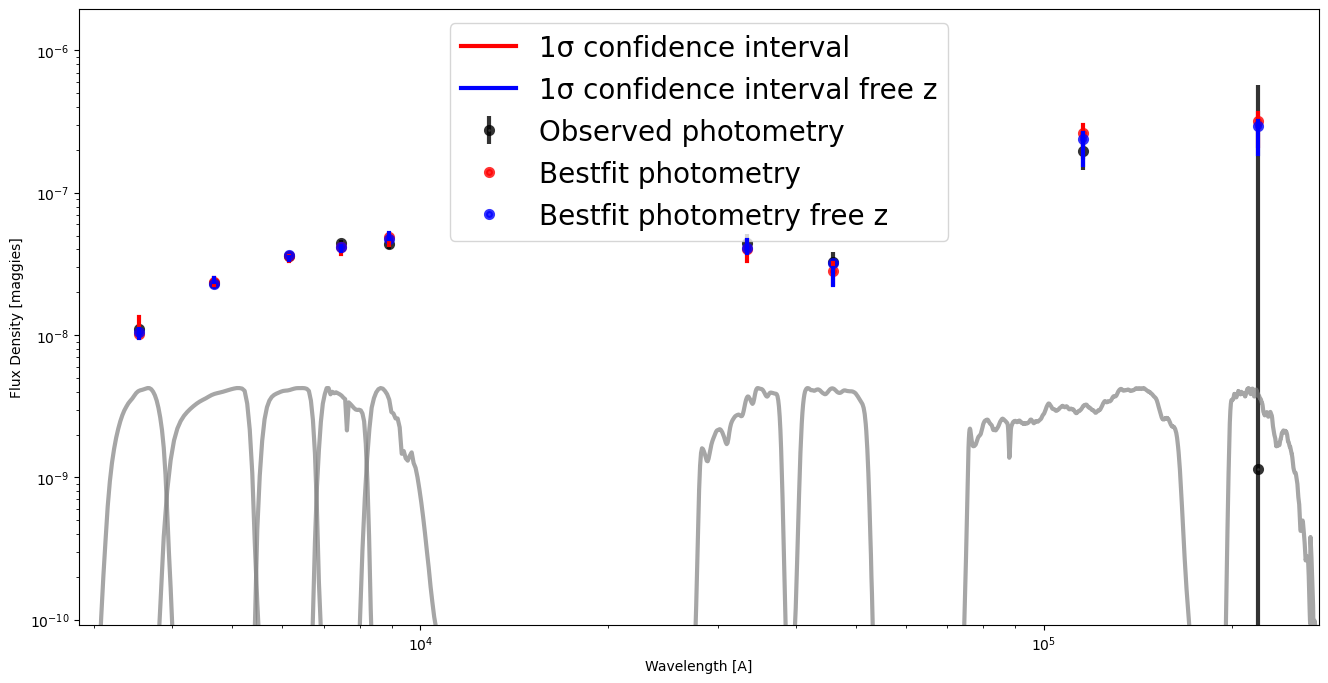

In [35]:
# Index of the best chain / parameter vector
imax_free = np.argmax(res_free['lnprobability'])

# Selecting the best parameter vector
if results_type == "emcee":
    i, j = np.unravel_index(imax_free, res_free['lnprobability'].shape)
    theta_max_free = res_free['chain'][i, j, :].copy()
    thin = 5
else:
    theta_max_free = res_free["chain"][imax_free, :]
    thin = 1

# cosmological redshifting
a = 1.0 + model_free.params.get('zred', 0.0) 

# photometric effective wavelengths
wphot = obs["phot_wave"]

# spectroscopic wavelengths
# *restframe* spectral wavelengths, since obs["wavelength"] is None
wspec = sps.wavelengths
wspec *= a #redshift them

# Find bounds 
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()*10

#mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
#mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

# Make plot of data and model
plt.figure(figsize=(16,8))


plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='black', 
         fmt='.', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='black', 
         markeredgewidth=3)

plt.errorbar(wphot, mphot_map,label='Bestfit photometry', color='red', fmt='.', markersize=10, ls='', lw=3, alpha=0.8, markeredgewidth=3)

plt.errorbar(wphot, mphot_map_free,label='Bestfit photometry free z', color='blue', fmt='.', markersize=10, ls='', lw=3, alpha=0.8, markeredgewidth=3)

# For one of the bestfit data point, it does not lie within the 1σ confidence interval.
#Therefore, I had to use a different way to plot the errrorbars since plt.errorbar does not want to plot errorbars which do not overlap with the data point.
for i in range(len(wphot)):
    if i==0:
        plt.plot([wphot[i],wphot[i]],[photo_min[i],photo_max[i]],color='red',lw=3,label='1σ confidence interval',zorder=10)
        plt.plot([wphot[i],wphot[i]],[photo_min_free[i],photo_max_free[i]],color='blue',lw=3,label='1σ confidence interval free z',zorder=10)
    else:
        plt.plot([wphot[i],wphot[i]],[photo_min[i],photo_max[i]],color='red',lw=3,zorder=10)
        plt.plot([wphot[i],wphot[i]],[photo_min_free[i],photo_max_free[i]],color='blue',lw=3,zorder=10)
        

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin/10,ymax])
plt.legend(loc='best', fontsize=20)

<font color='red'> Answers:

In [36]:
# Space to work

# Get best fit parameters

free_params_names_free=res_free['theta_labels']
bestfit0=res_free['bestfit']
bestfit1=bestfit0['parameter']
print('The best fit parameters for the free redshift are:')
for i in range(len(free_params_names)):
    print('{} {:.2e}'.format(free_params_names_free[i],bestfit1[i]))

The best fit parameters for the free redshift are:
zred 1.91e-01
mass 1.60e+10
logzsol -6.87e-02
dust2 4.33e-01
tage 1.60e+00


In [37]:
σ1_m_free=np.quantile(flatten_chains_free,0.159,axis=0)
σ1_p_free=np.quantile(flatten_chains_free,0.841,axis=0)
σ2_m_free=np.quantile(flatten_chains_free,0.023,axis=0)
σ2_p_free=np.quantile(flatten_chains_free,0.977,axis=0)
σ3_m_free=np.quantile(flatten_chains_free,0.2/100,axis=0)
σ3_p_free=np.quantile(flatten_chains_free,99.8/100,axis=0)

print('1σ interval:')
for i in range(len(free_params_names_free)):
    print('{}: {:.2e} to {:.2e}'.format(free_params_names_free[i],σ1_m_free[i],σ1_p_free[i]))
print()
print('2σ interval:')
for i in range(len(free_params_names_free)):
    print('{}: {:.2e} to {:.2e}'.format(free_params_names_free[i],σ2_m_free[i],σ2_p_free[i]))
print()
print('3σ interval:')
for i in range(len(free_params_names_free)):
    print('{}: {:.2e} to {:.2e}'.format(free_params_names_free[i],σ3_m_free[i],σ3_p_free[i]))

1σ interval:
zred: 5.04e-02 to 1.04e-01
mass: 1.90e+09 to 7.20e+09
logzsol: -5.41e-01 to 9.44e-02
dust2: 2.99e-01 to 5.06e-01
tage: 4.80e+00 to 1.14e+01
tau: 2.80e+00 to 1.83e+01

2σ interval:
zred: 3.24e-02 to 1.81e-01
mass: 8.55e+08 to 1.52e+10
logzsol: -8.84e-01 to 1.81e-01
dust2: 2.08e-01 to 6.07e-01
tage: 2.38e+00 to 1.34e+01
tau: 8.75e-01 to 2.71e+01

3σ interval:
zred: 2.20e-02 to 2.49e-01
mass: 4.83e+08 to 2.33e+10
logzsol: -1.20e+00 to 1.89e-01
dust2: 1.32e-01 to 6.76e-01
tage: 1.53e+00 to 1.38e+01
tau: 4.79e-01 to 2.96e+01


In [38]:
redshift_chain=flatten_chains_free[:,0]
cond=redshift_chain>=0.15397674
frac=len(redshift_chain[cond])/len(redshift_chain)

In [39]:
import scipy

In [40]:
sig_red=scipy.stats.norm.isf(frac)
sig_red

1.7693033678278438

<font color='red'>
Allowing the redshift to be free slightly changed the bestfit parameters and the confidence intervals, although all the parameters which are free in both fits are consistent with each other with 1$\sigma$. The 1$\sigma$ intervals for both fits for the stellar mass are consistent with each other. The redshift of the galaxy according to Chang et al. is 0.15397674. This redshift is not within the 1$\sigma$ confidence interval from our fit. The Chang et al. redshift is consistent with our fit within 1.77$\sigma$. 

# Section 2 

#### Step 1: Covariance

First lets look at the covariance of constrained parameters for one of your fits. Plot a corner plot of the prospector outputs, showing the 68% and 95% 2D contours. Remember, you can refer to the Prospector Example notebook on how to make a corner plot.

Are there any degeneracies between parameters in the fit? What does this mean?<br> How do the degeneracies change if we fix redshift or if we try to vary it?

## <font color='red'> Corner plot fixed redshift

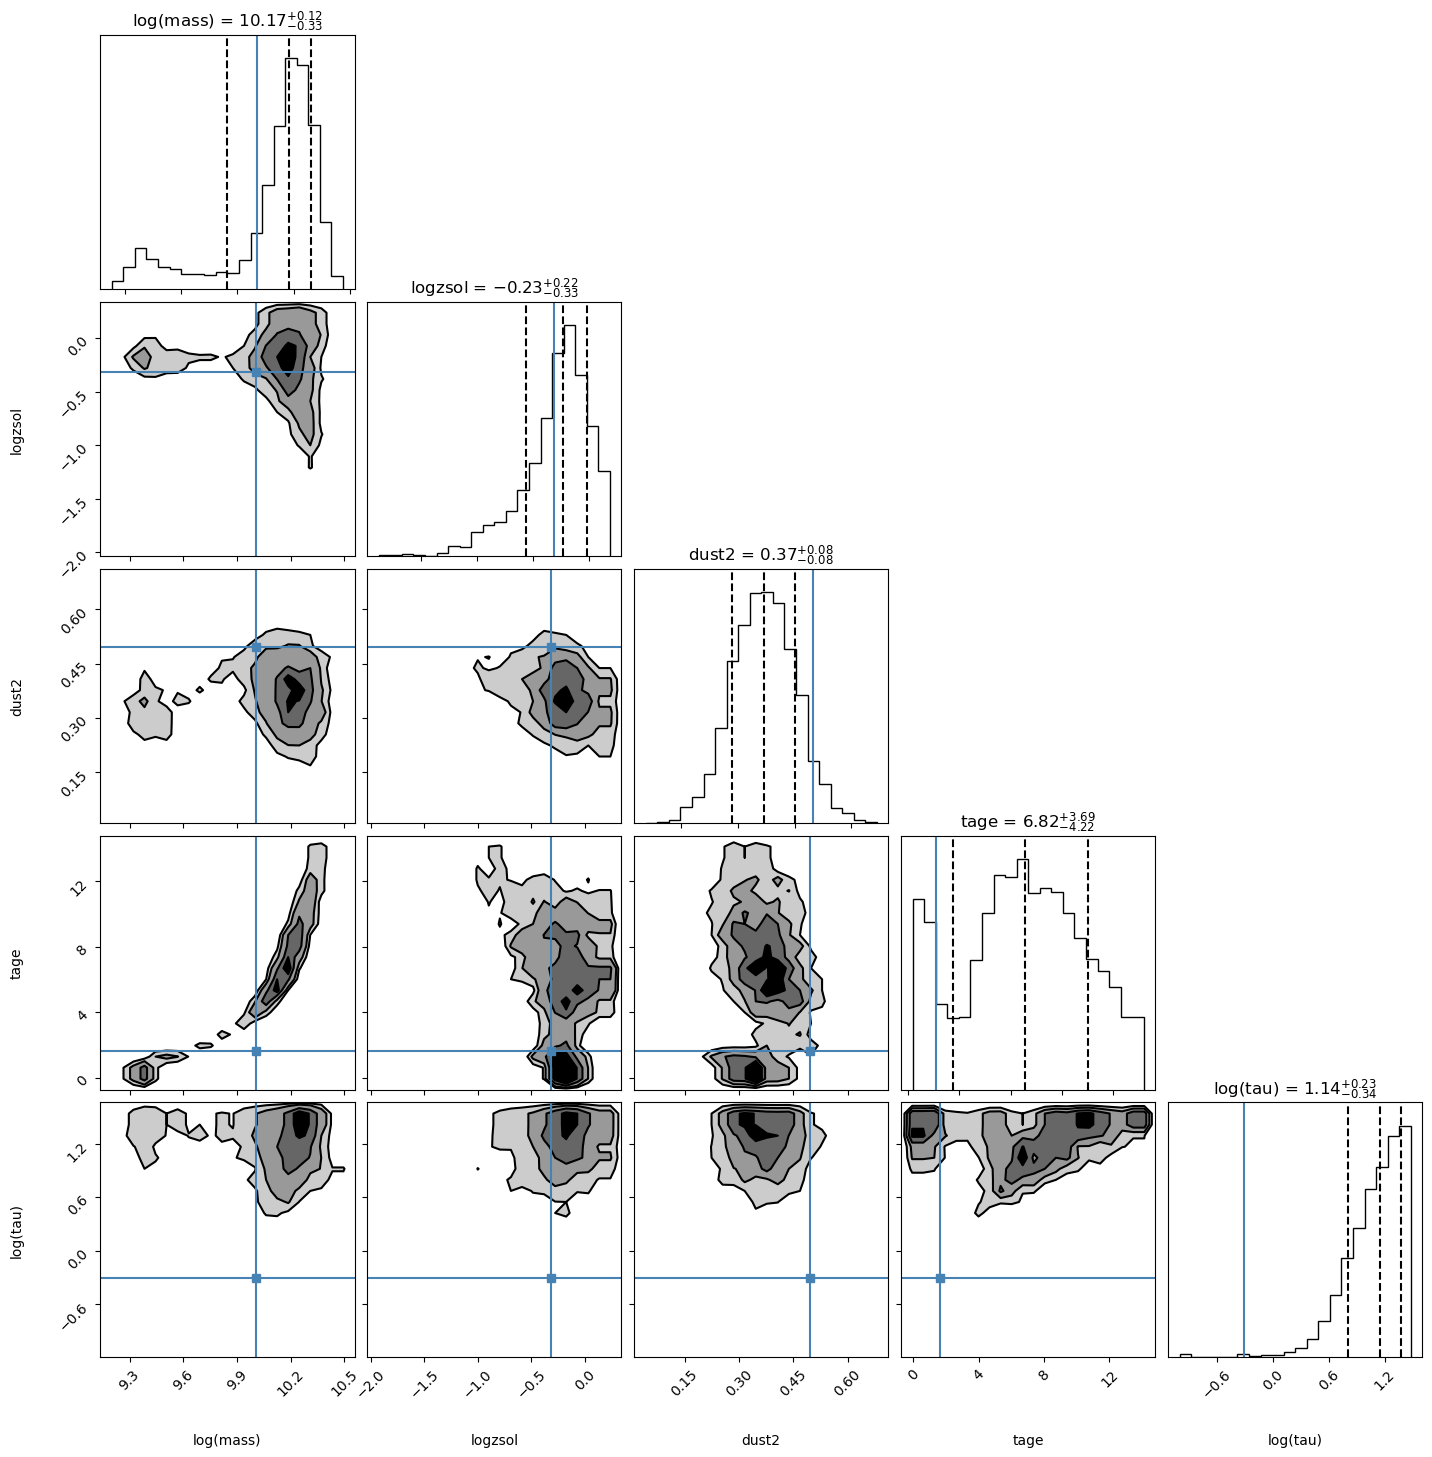

In [41]:
cornerfig = reader.subcorner(res, start=0, thin=thin, truths=theta_max, 
                             fig=plt.subplots(5,5,figsize=(15,15))[0])

## <font color='red'> Corner plot for fit with free redshift

[ 1.91272317e-01  1.59885482e+10 -6.87040094e-02  4.32888774e-01
  1.59980377e+00  5.05249475e-01]


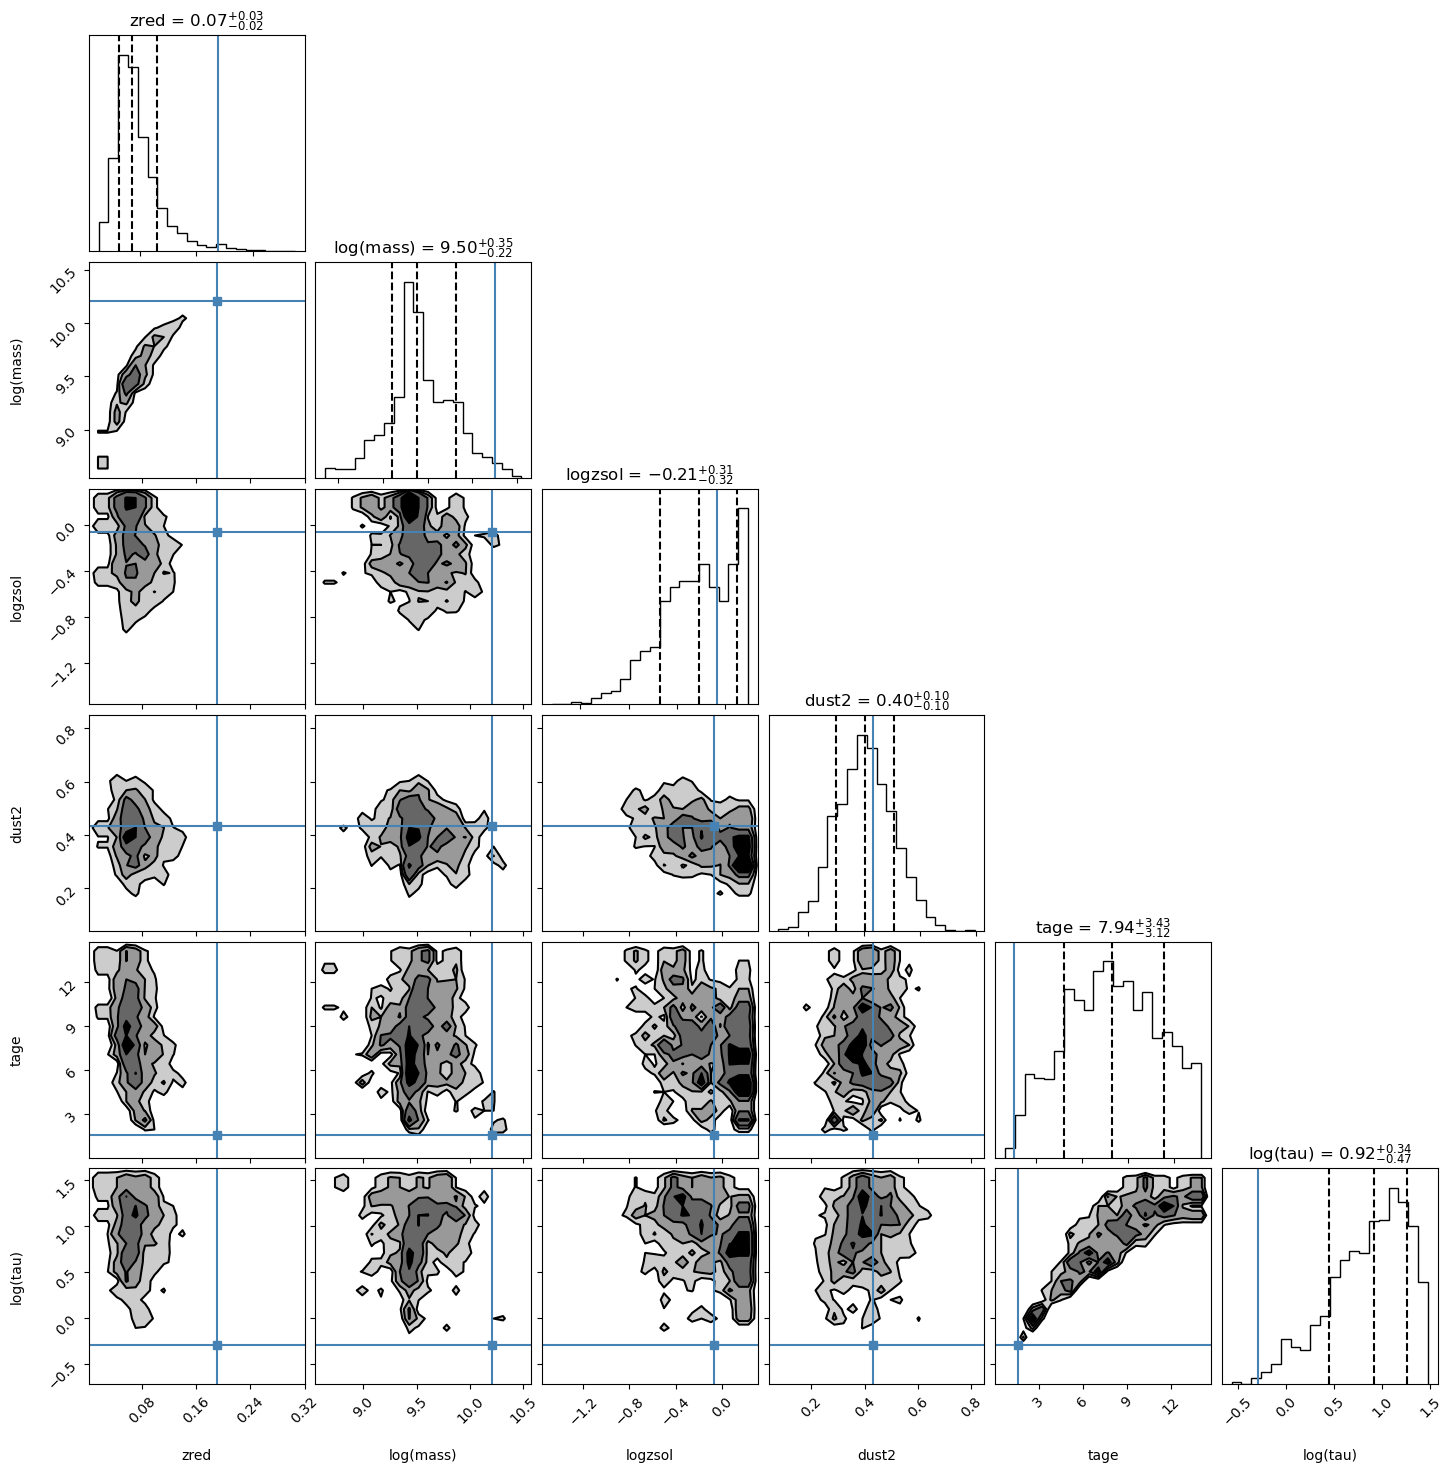

In [42]:
cornerfig = reader.subcorner(res_free, start=0, thin=thin,truths=theta_max_free, 
                             fig=plt.subplots(6,6,figsize=(15,15))[0])
print(theta_max_free)

### <font color='red'> Prospector is messing with the values on top of the histrograms. Since this is not the point of the assignment, I was told to give up.

<font color='red'>
Degeneracy means that similar likelihoods can be obtained from different combinations of parameters. For the fixed redshift, there is a clear degeneracy between log(mass) and tage. It makes sense that the mass is positively correlated with the galaxy's age since bigger galaxies have their peak in star formation earlier in their lifetime so more time ago. The degeneracies change when we set the redshift free. Then, the redshift is degenerate with the mass and tage is degenerate with tau. The mass is degenerate with redshift because objects further away need to be more massive to be detected (assuming a mass or flux limited survey) than closer objects. tage is related to tau and this means that older galaxies have a slower decay in their SFR.

#### Step 2: Covariance matrix

The covariance matrix describes the uncertainties of parameters, and their covariance with each other. Make the covariance matrix for one of your fits and plot it.

Looking at the contour plot, was this a reasonable thing to do? i.e. Is your covariance matrix a good descriptor of your posterior

In [44]:
# Space to work
cov_matrix_free=np.cov(flatten_chains_free.T)
cov_matrix_free

array([[ 1.19816542e-03,  1.15666043e+08, -9.93947514e-04,
        -7.30281625e-04, -4.65188179e-02, -3.61282781e-02],
       [ 1.15666043e+08,  1.21038220e+19, -1.29915046e+08,
        -6.60625608e+07, -2.75499672e+09, -1.52339684e+09],
       [-9.93947514e-04, -1.29915046e+08,  8.87140044e-02,
        -1.08762521e-02, -2.40952737e-01, -3.92297547e-01],
       [-7.30281625e-04, -6.60625608e+07, -1.08762521e-02,
         1.01485108e-02,  2.11332338e-02,  9.32461573e-02],
       [-4.65188179e-02, -2.75499672e+09, -2.40952737e-01,
         2.11332338e-02,  9.13446830e+00,  1.48892680e+01],
       [-3.61282781e-02, -1.52339684e+09, -3.92297547e-01,
         9.32461573e-02,  1.48892680e+01,  5.37736764e+01]])

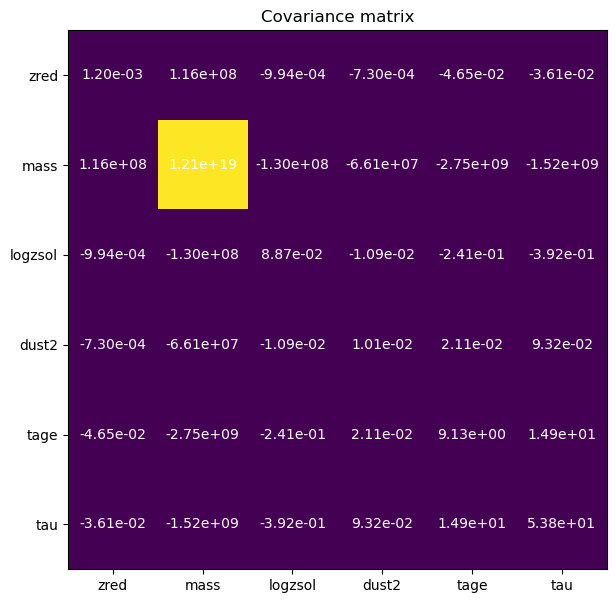

In [89]:
fig=plt.subplots(1,1,figsize=(7,7))
im = plt.imshow(abs(cov_matrix_free))
plt.xticks(np.arange(len(cov_matrix_free)), labels=res_free['theta_labels'])
plt.yticks(np.arange(len(cov_matrix_free)), labels=res_free['theta_labels'])
plt.title('Covariance matrix')
for i in range(len(cov_matrix_free)):
    for j in range(len(cov_matrix_free)):
        text = plt.text(j, i, '{:.2e}'.format(cov_matrix_free[i, j]),
                       ha="center", va="center", color="w")

#### <font color='red'> This was not a reasonable thing to do. The range in the values of the fitted parameters spans 10-12 orders of magnitudes. We do not get a good idea of the correlation since the values in the covariance matrix are not normalized such that we cannot compare the different values well.

In [46]:
corr_matrix=np.corrcoef(flatten_chains_free.T)
corr_matrix

array([[ 1.        ,  0.96047535, -0.09640709, -0.20942611, -0.44466059,
        -0.14233248],
       [ 0.96047535,  1.        , -0.12537244, -0.18849202, -0.26201019,
        -0.05971273],
       [-0.09640709, -0.12537244,  1.        , -0.3624783 , -0.26766657,
        -0.17961171],
       [-0.20942611, -0.18849202, -0.3624783 ,  1.        ,  0.06941018,
         0.12622487],
       [-0.44466059, -0.26201019, -0.26766657,  0.06941018,  1.        ,
         0.67181059],
       [-0.14233248, -0.05971273, -0.17961171,  0.12622487,  0.67181059,
         1.        ]])

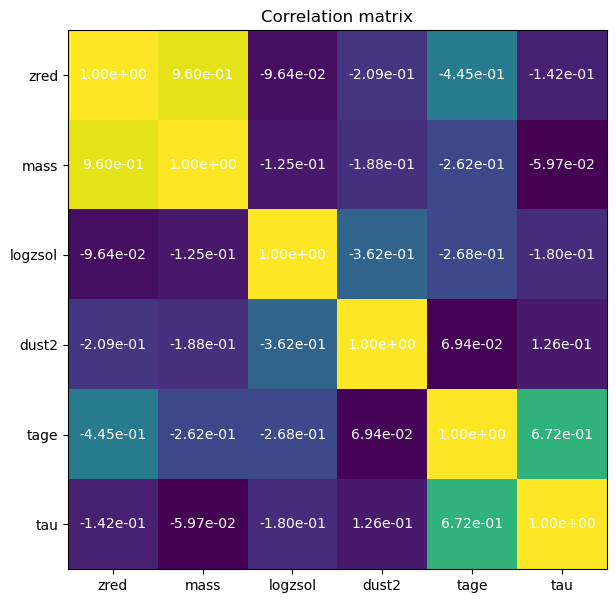

In [88]:
fig=plt.subplots(1,1,figsize=(7,7))
im = plt.imshow(abs(corr_matrix))
plt.xticks(np.arange(len(corr_matrix)), labels=res_free['theta_labels'])
plt.yticks(np.arange(len(corr_matrix)), labels=res_free['theta_labels'])
plt.title('Correlation matrix')
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        text = plt.text(j, i, '{:.2e}'.format(corr_matrix[i, j]),
                       ha="center", va="center", color="w")

#### <font color='red'> The correlation matrix is a better option to visualise the correlation between our different fitted parameters than the covariance matrix. It is a reasonable reasonable thing to do although I prefer using corner plots since we get to see the posterior and the confidence interval of our data.

#### Step 3: Covariance of magnitude errors

So far, Prospector has assumed the uncertainties in the magnitudes/fluxes are independent of each other. In practice this might not be true. For this excercise, assume the correlation between the flux in each band is X%.

Plot the covariance matrix, with and without the correlated errors.

In [48]:
# Space to work

band=obs['phot_wave']
photo_obs=obs['maggies']
u_photo_obs=obs['maggies_unc']

# If the fluxes in each band are uncorrelated, then the diagonals are the uncertainties squared and the off-diagonal are 0.

uncorr_cov=np.zeros((len(band),len(band)))
for i in range(len(band)):
    uncorr_cov[i,i]=u_photo_obs[i]**2

# Correlated fluxes in different bands
corr_cov=np.copy(uncorr_cov)

for i in range(len(band)):
    for j in range(i+1,len(band)):
        un=u_photo_obs[i]*0.1*u_photo_obs[j]*0.1
        rand=np.random.rand(1)-0.5
        corr_cov[i,j]=rand**-1*un
        corr_cov[j,i]=rand**-1*un

/var/folders/xn/bk5wm_rj6yzd__fv_1wy3w7m0000gn/T/ipykernel_36784/3691685078.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr_cov[i,j]=rand**-1*un
/var/folders/xn/bk5wm_rj6yzd__fv_1wy3w7m0000gn/T/ipykernel_36784/3691685078.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr_cov[j,i]=rand**-1*un


/var/folders/xn/bk5wm_rj6yzd__fv_1wy3w7m0000gn/T/ipykernel_36784/2413054710.py:3: RuntimeWarning: divide by zero encountered in log10
  im = plt.imshow(np.log10((uncorr_cov)))


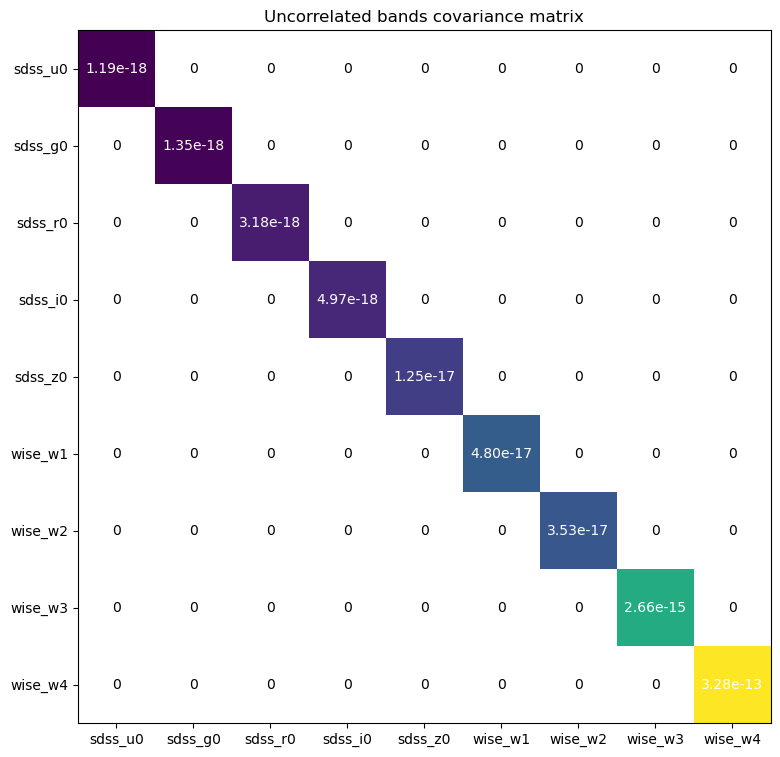

In [87]:
# Plotting the uncorrelated covariance matrix
fig=plt.subplots(1,1,figsize=(9,9))
im = plt.imshow(np.log10((uncorr_cov)))
names=obs['filternames']
plt.xticks(np.arange(len(uncorr_cov)), labels=names)
plt.yticks(np.arange(len(uncorr_cov)), labels=names)
plt.title('Uncorrelated bands covariance matrix')
for i in range(len(uncorr_cov)):
    for j in range(len(uncorr_cov)):
        if(uncorr_cov[i, j]==0):
            text = plt.text(j, i, 0,
                       ha="center", va="center", color="black")
        else:
            text = plt.text(j, i, '{:.2e}'.format(uncorr_cov[i, j]),
                       ha="center", va="center", color="w")
        

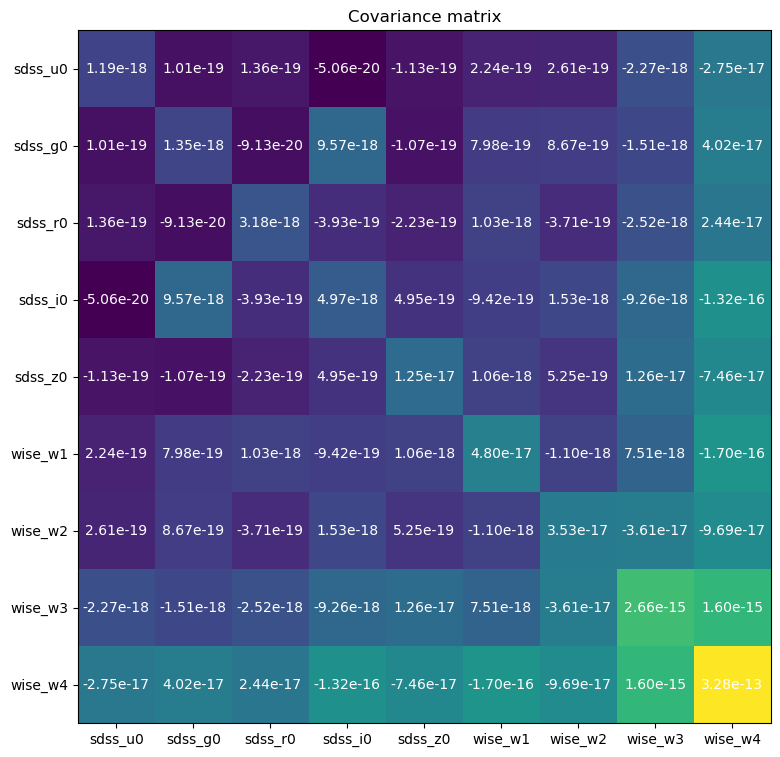

In [86]:
# Plotting the correlated
fig=plt.subplots(1,1,figsize=(9,9))
im = plt.imshow(np.log10((abs(corr_cov))))
plt.xticks(np.arange(len(uncorr_cov)), labels=names)
plt.yticks(np.arange(len(uncorr_cov)), labels=names)
plt.title('Covariance matrix')
for i in range(len(uncorr_cov)):
    for j in range(len(uncorr_cov)):
        text = plt.text(j, i, '{:.2e}'.format(corr_cov[i, j]),
                    ha="center", va="center", color="w")

Re-compute the goodness of fit with the correlated errors. <br>
Did the goodness-of-fit get worse or better, why?

<font color='red'>
From the notes: $\chi^2=(m-d)^TC^{-1}(m-d)$

In [51]:
# Get χ2 for when correlated errors are considered

model=res_free['bestfit']['photometry']
data=obs['maggies']

invert_corr_cov=np.linalg.inv(corr_cov)
χ2_corr=np.matmul(np.matmul(np.transpose(model-data),invert_corr_cov),(model-data))
χ2_corr

2.852588485451203

In [52]:
# Get χ2 for when correlated errors are not considered
invert_uncorr_cov=np.linalg.inv(uncorr_cov)
χ2_uncorr=np.matmul(np.matmul(np.transpose(model-data),invert_uncorr_cov),(model-data))
χ2_uncorr

5.068101310412011

In [53]:
# Get χ2 a different way for when correlated errors are not considered. Sanity check.
χ2_uncorr=np.sum(((data - model) / obs['maggies_unc'])**2)
χ2_uncorr

5.068101310412011

##### <font color='red'> My goodness-of-fit got very slightly better. My $\chi^2$ became slightly smaller when I applied the correlation to the errors. In reality, the reduced $\chi^2$ is not ideal to use here. Both the data and the model are correlated so that we only get an estimate of the degrees of freedom. We see that $\chi^2$ becomes smaller once correlations between data points are taken into account, so compared to the case where we neglect to take into account the correlations, our $\chi^2$ becomes smaller, indicating a better fit between the data and the model. If the "true" degrees of freedom are less than 4, the $\chi^2$ considering data correlation becomes closer to 1, which is the goal for a fit which neither over-estimates or underestimates the data.

# Section 3 

#### Estimating the uncertainties

For this section, we will use the output catalogs, since running prospector on all 800000 galaxies would be a waste of computing for this class.

Plot a histogram of a given measured quantity (stellar mass, redshift, etc). Choose the range and bin size appropriately so that we can see the full distribution.

In [268]:
catalog

<Table length=858365>
   id   lmass2_5_all lmass16_all lmass50_all ... flag_w4 flag_chi2  flag
 int32    float32      float32     float32   ...  int16    int16   int16
------- ------------ ----------- ----------- ... ------- --------- -----
      3        10.54       10.61       10.68 ...       2         1     0
      5         11.1       11.18       11.25 ...       2         1     0
      8        10.77       10.85       10.91 ...       2         1     0
     12         11.4       11.48       11.57 ...       2         1     0
     14         8.68        9.02        9.37 ...       0         0     0
     15         9.72        9.79        9.88 ...       1         1     0
    ...          ...         ...         ... ...     ...       ...   ...
2506726          9.0        9.06        9.14 ...       1         1     1
2506727        11.19       11.25       11.33 ...       2         1     0
2506731         10.1        10.2       10.36 ...       1         1     1
2506738         10.5       10.61        10.7 ...       2         1     1
2506739        11.32       11.41       11.48 ...       2         1     0
2506741         8.94         9.0        9.07 ...       1         1     1
2506743          9.0        9.06        9.13 ...       1         1     1

In [54]:
# Space to work
cond_good=(catalog['flag_chi2']==1)
mucho_stelmass=np.array(catalog['lmass50_all'][cond_good].data)

Text(0, 0.5, 'Counts')

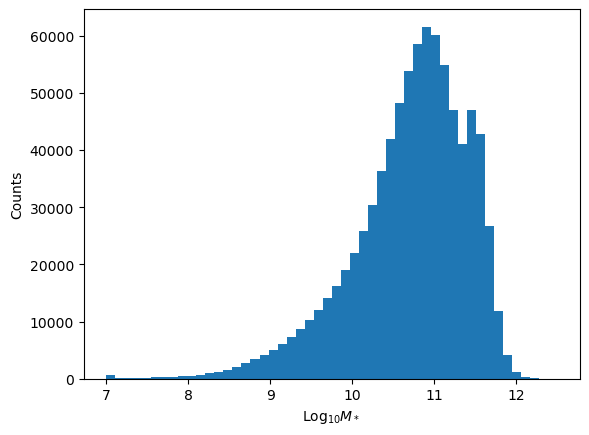

In [55]:
vals,edges,_=plt.hist(mucho_stelmass,bins=50,range=[np.min(mucho_stelmass),np.max(mucho_stelmass)])
plt.xlabel(r'Log$_{10} M_*$')
plt.ylabel('Counts')

In [56]:
## The number of thing in each bin is taken to be the mean and the uncertainty is sqrt(N). 

errors_true=np.sqrt(vals)
errors_true

array([ 24.18677324,  10.29563014,  11.3137085 ,  12.        ,
        14.4222051 ,  14.83239697,  16.76305461,  18.734994  ,
        21.16601049,  23.06512519,  27.07397274,  30.34798181,
        34.82814953,  39.73663297,  46.11941023,  51.60426339,
        59.1776985 ,  64.52906322,  71.3792687 ,  78.2879301 ,
        85.35806933,  92.93008124, 101.00495037, 109.47602477,
       118.85705701, 127.20455967, 138.00724619, 148.49579119,
       160.79179084, 174.37889781, 190.69347131, 204.81943267,
       219.43336118, 231.9116211 , 241.85532866, 248.11489274,
       245.14893432, 234.24346309, 216.89628858, 202.50925905,
       216.804059  , 206.88160866, 163.16862443, 108.8025735 ,
        64.70703208,  34.17601498,  15.65247584,   6.8556546 ,
         2.        ,   1.41421356])

Text(0, 0.5, 'Counts')

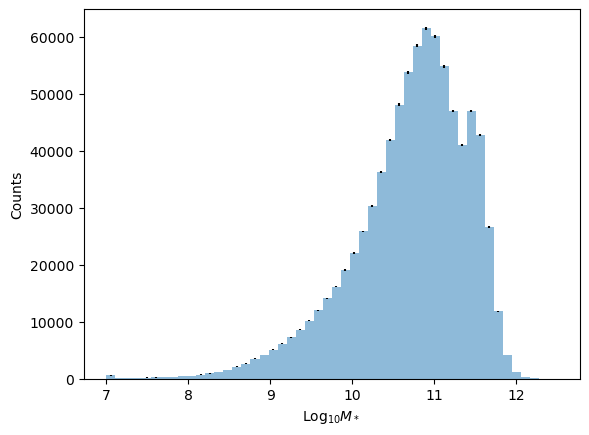

In [57]:
plt.hist(mucho_stelmass,bins=edges,range=[np.min(mucho_stelmass),np.max(mucho_stelmass)],alpha=0.5)
plt.errorbar((edges[1:]+edges[:-1])/2,vals,yerr=errors_true,fmt=' ',color='black')
plt.xlabel(r'Log$_{10} M_*$')
plt.ylabel('Counts')

There are a limited number of objects in each histogram bin. Add shot, or Poisson, noise to the histogram bars to show this. These will be your "analytic" error bars.

Now split the data into N subsets and compute the jackknife covarinace of the histogram bins.

* How does it compare to the analytic errors?
* Are the bins independent?
* What happens if you make N very large or very small?


In [58]:
# Space to work

N_sub=5000
new_data=np.array_split(mucho_stelmass,N_sub)
#new_data=np.random.choice(mucho_stelmass,(N_sub,int(np.floor(len(mucho_stelmass)/N_sub))),replace=False)
#print(new_data.shape)
jack_matrix=[]
#jack_matrix2=[]
#print(len(new_data))
for i in range(len(new_data)):
    #data2=new_data[:i]+new_data[i+1:]
    #thing=np.concatenate(data2).flatten()#ravel()
    #print(thing)
    #vals,_=np.histogram(thing,bins=edges)
    #jack_matrix.append(vals)
    #print(thing.shape)
    #x0=np.copy(new_data)
    x0=new_data.copy()
    #vals,_=np.histogram((np.delete(x0,i)).flatten(),bins=edges)
    vals,_=np.histogram((x0.pop(i)).flatten(),bins=edges)
    jack_matrix.append(vals)
    

In [59]:
jack_matrix=np.array(jack_matrix)

cov_jack=np.cov(jack_matrix.T)*(N_sub-1)*(N_sub-1)/N_sub
diag_jack=[]
for i in range(len(errors_true)):
    diag_jack.append(np.sqrt(cov_jack[i,i]))
cov_jack

array([[ 2.11613169e+03,  5.59688040e+00,  4.70145952e+01, ...,
         3.50029980e+00, -4.67906400e-01, -2.33953200e-01],
       [ 5.59688040e+00,  1.11730449e+02,  2.86342720e-01, ...,
         3.59928000e-03, -8.47830400e-02, -4.23915200e-02],
       [ 4.70145952e+01,  2.86342720e-01,  1.30697055e+02, ...,
        -2.03159360e-01, -1.02379520e-01, -5.11897600e-02],
       ...,
       [ 3.50029980e+00,  3.59928000e-03, -2.03159360e-01, ...,
         4.85484884e+01, -3.75924800e-02, -1.87962400e-02],
       [-4.67906400e-01, -8.47830400e-02, -1.02379520e-01, ...,
        -3.75924800e-02,  3.99600064e+00, -1.59968000e-03],
       [-2.33953200e-01, -4.23915200e-02, -5.11897600e-02, ...,
        -1.87962400e-02, -1.59968000e-03,  1.99880016e+00]])

Text(0, 0.5, 'Errors Log$_{10}M_*$')

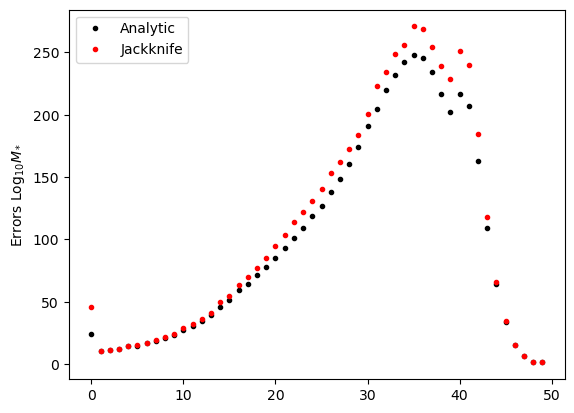

In [85]:
plt.errorbar(np.linspace(0,49,50),errors_true,fmt='.',color='black',label='Analytic')
plt.errorbar(np.linspace(0,49,50),diag_jack,fmt='.',color='red',label='Jackknife')
plt.legend()
plt.ylabel(r'Errors Log$_{10}M_*$')

In [61]:
compare_errors=[]

for i in range(50):
    compare_errors.append((np.sqrt(cov_jack[i,i])-errors_true[i])/errors_true[i]*100)
#plt.hist(compare_errors,bins=50)
#print(np.median(compare_errors))
#compare_errors

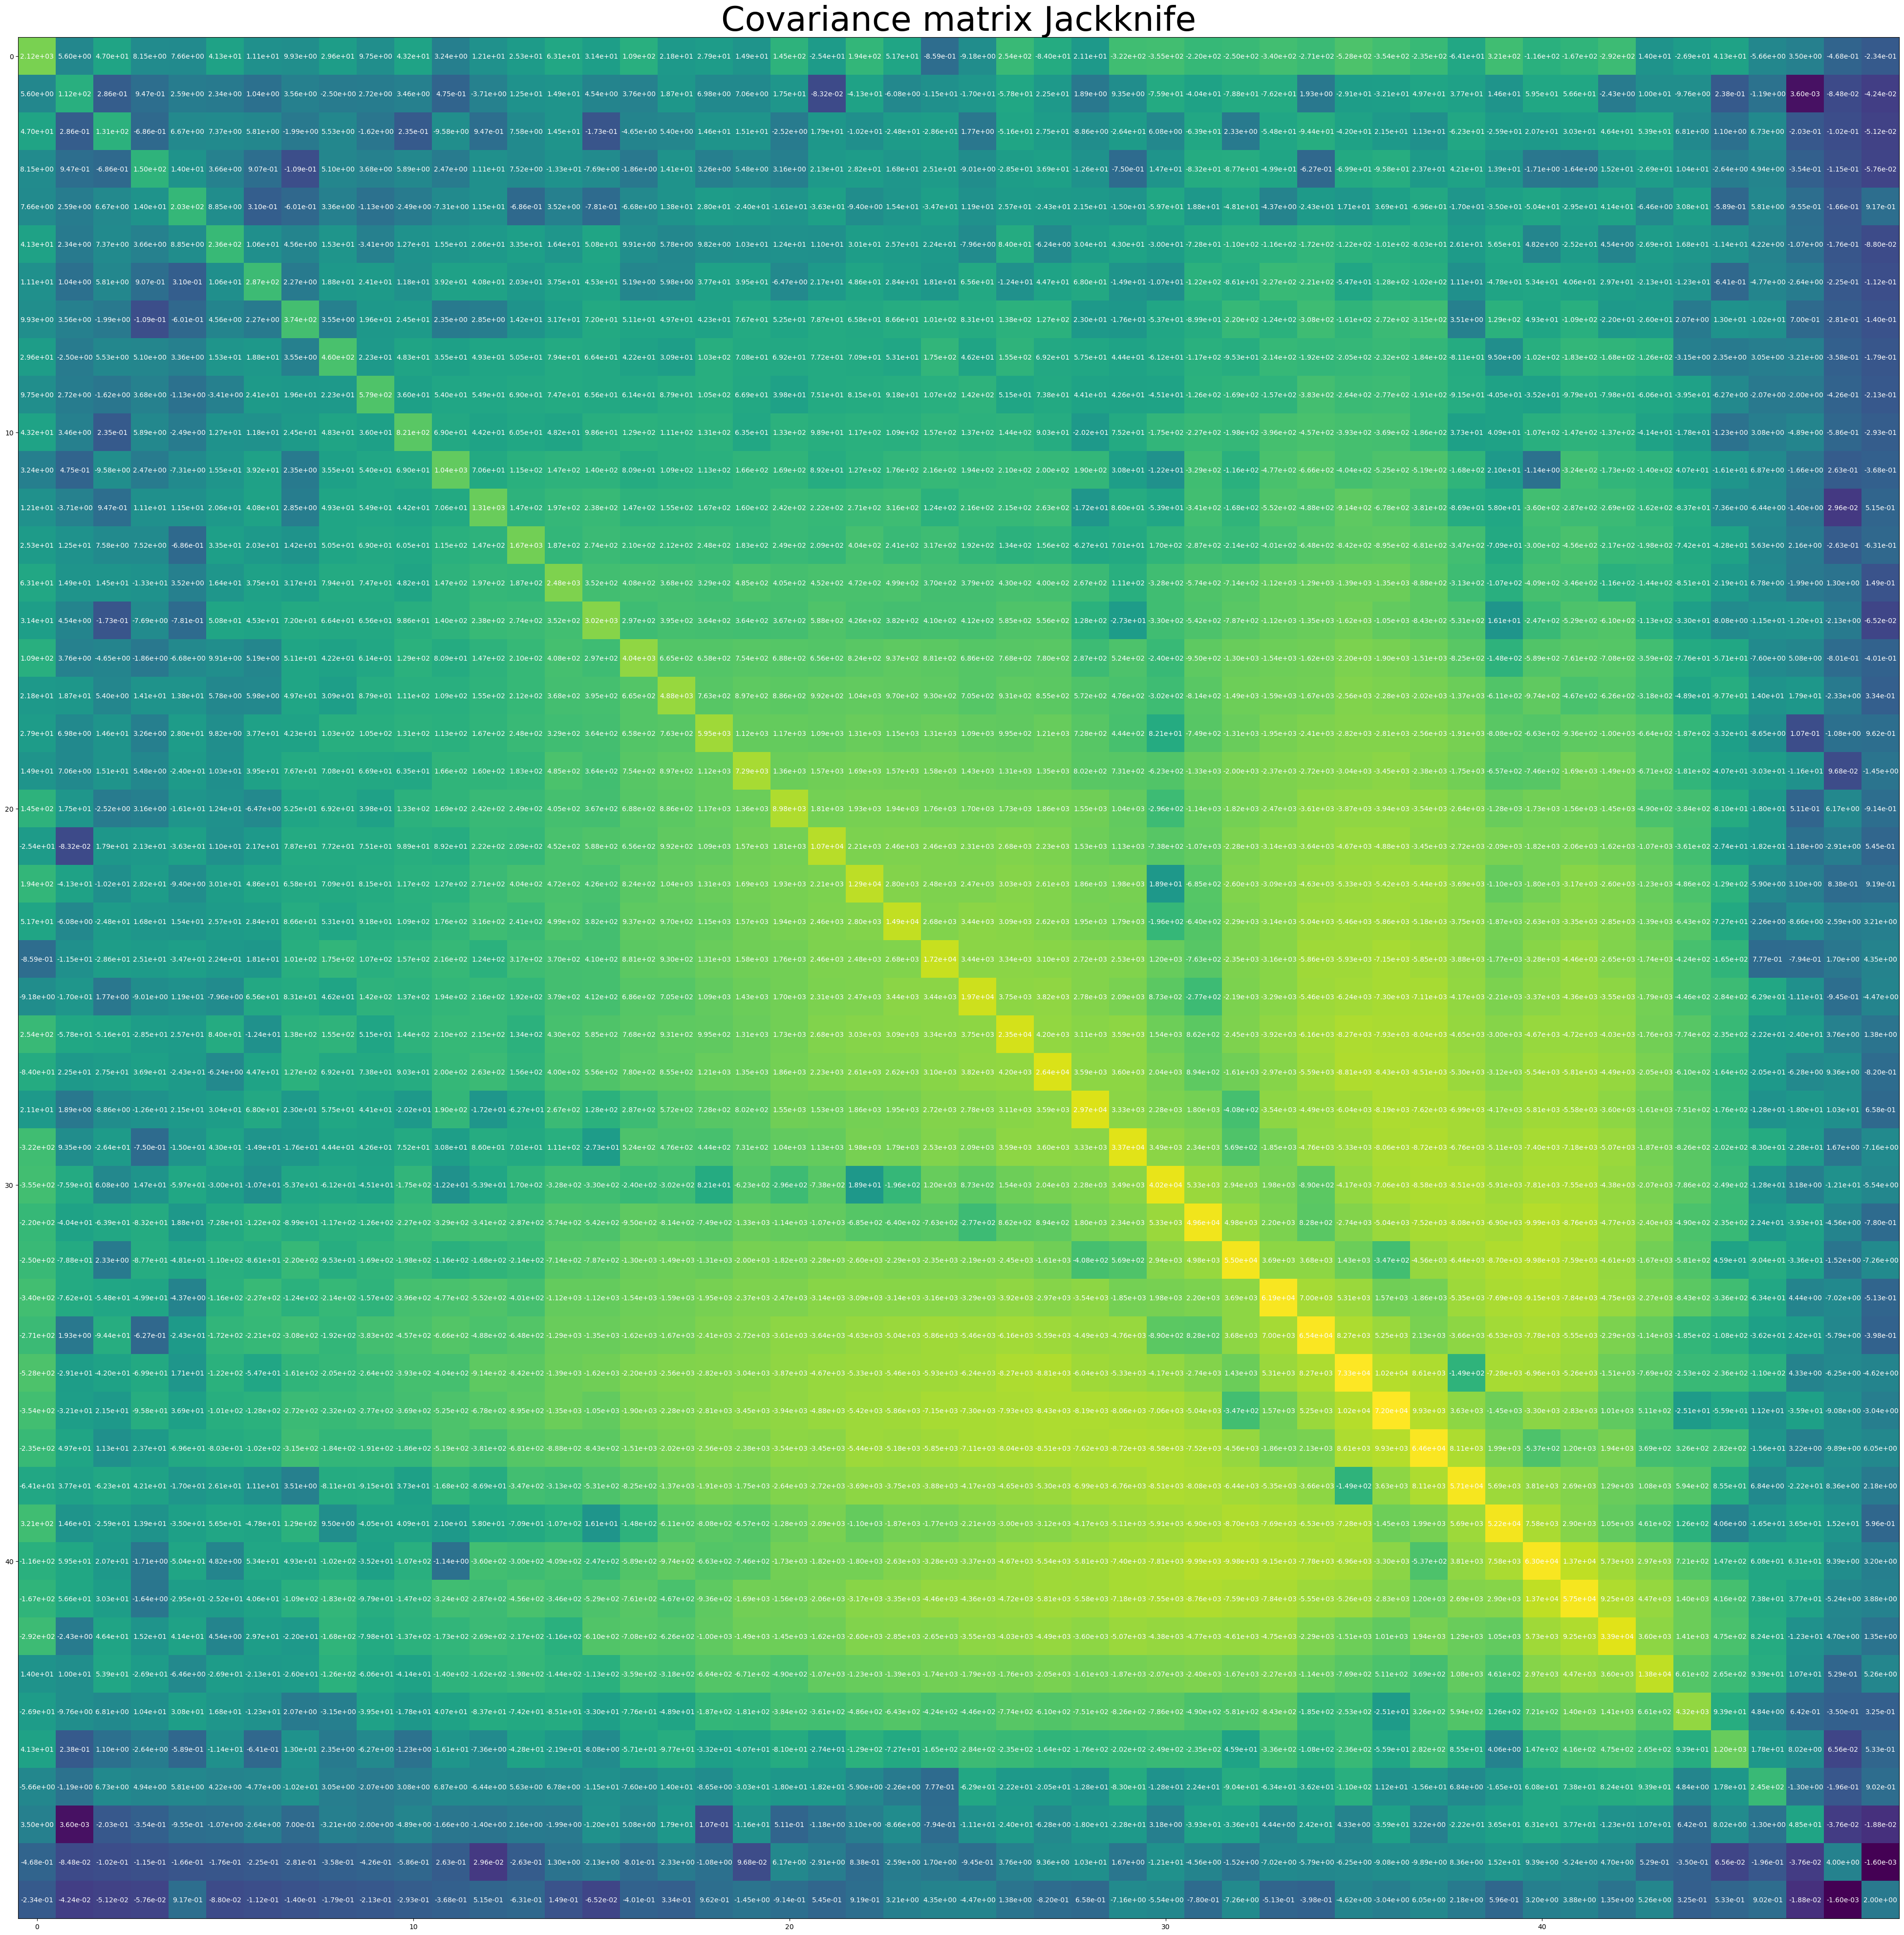

In [84]:
# Plotting the correlated
fig=plt.subplots(1,1,figsize=(50,50))
im = plt.imshow(np.log10((abs(cov_jack))),vmin=np.min(np.log10(abs(cov_jack))),vmax=np.max(np.log10(abs(cov_jack))))
#plt.xticks(np.arange(len(corr_jack)), labels=names)
#plt.yticks(np.arange(len(corr_jack)), labels=names)
plt.title('Covariance matrix Jackknife',fontsize=50)
for i in range(len(cov_jack)):
    for j in range(len(cov_jack)):
        text = plt.text(j, i, '{:.2e}'.format(cov_jack[i, j]),
                    ha="center", va="center", color="w")

/var/folders/xn/bk5wm_rj6yzd__fv_1wy3w7m0000gn/T/ipykernel_36784/1802052346.py:8: RuntimeWarning: divide by zero encountered in log10
  im = plt.imshow(np.log10(errors_true_matrix),vmin=np.min(np.log10(abs(cov_jack))),vmax=np.max(np.log10(abs(cov_jack))))


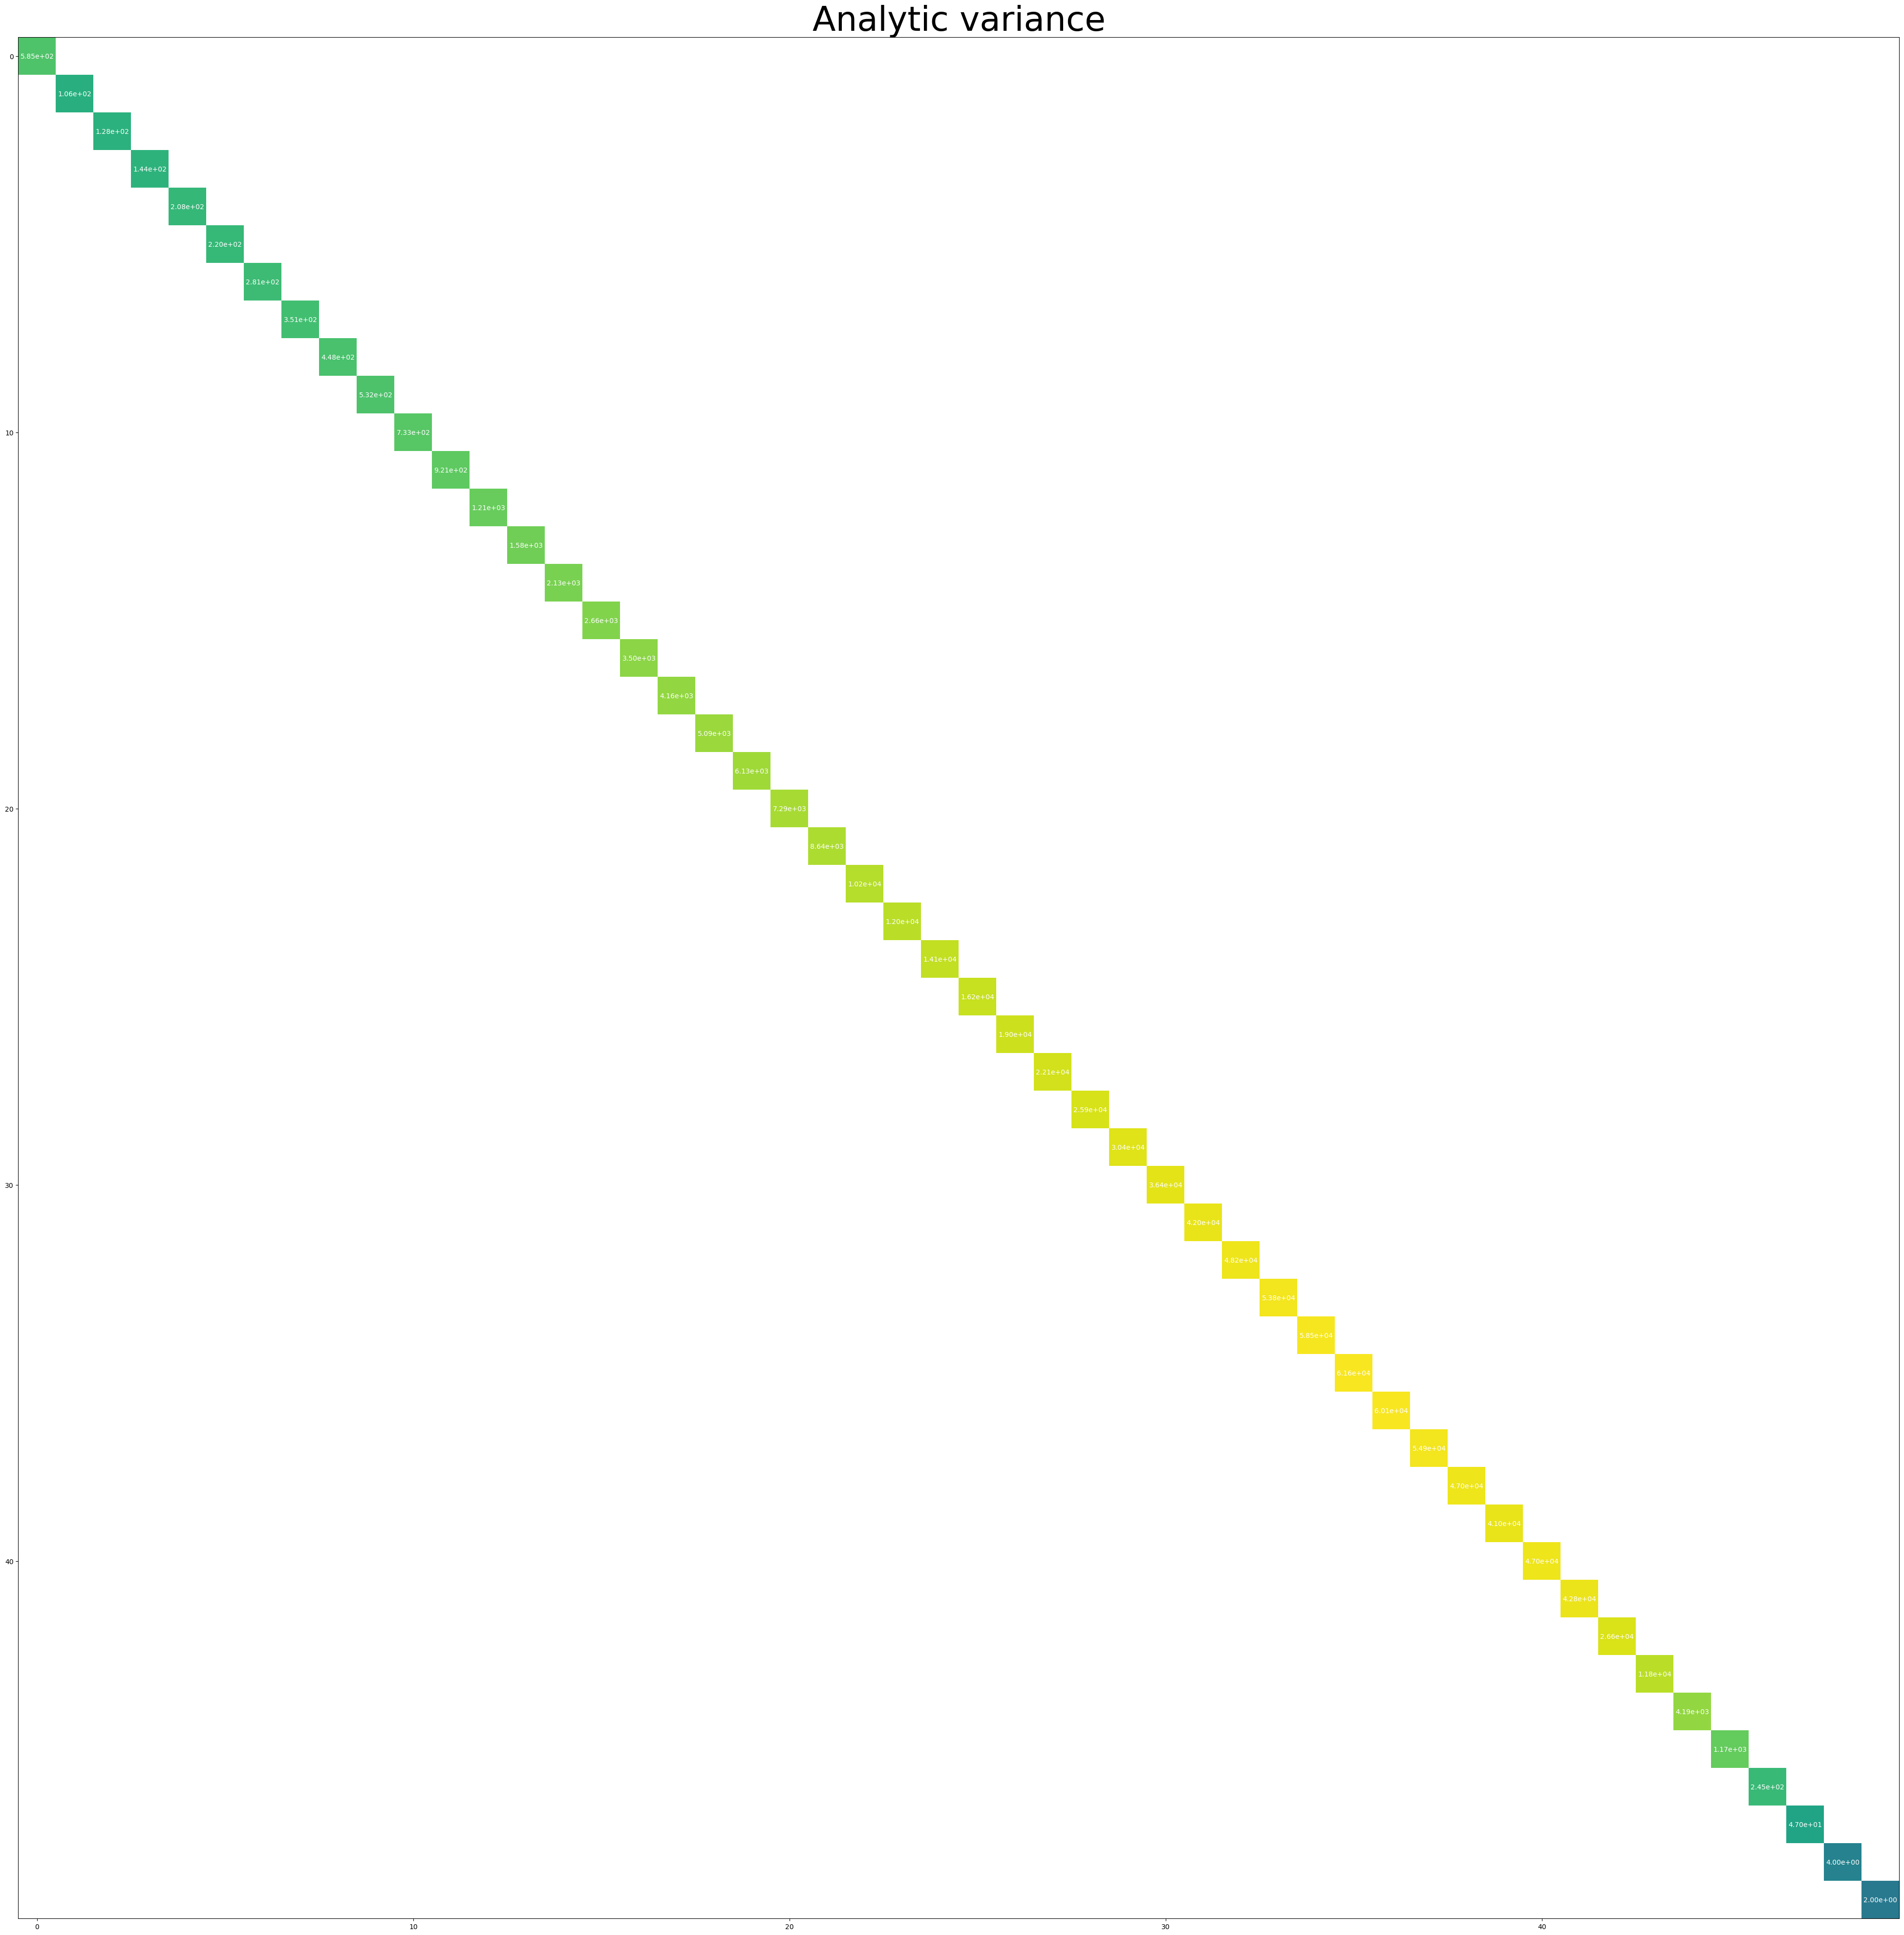

In [82]:
# Plotting the analytic variance

errors_true_matrix=np.zeros((50,50))
for i in range(50):
    errors_true_matrix[i,i]=errors_true[i]**2

fig=plt.subplots(1,1,figsize=(50,50))
im = plt.imshow(np.log10(errors_true_matrix),vmin=np.min(np.log10(abs(cov_jack))),vmax=np.max(np.log10(abs(cov_jack))))
#plt.xticks(np.arange(len(corr_jack)), labels=names)
#plt.yticks(np.arange(len(corr_jack)), labels=names)
plt.title('Analytic variance',fontsize=50)
for i in range(len(errors_true_matrix)):
    for j in range(len(errors_true_matrix)):
        text = plt.text(j, i, '{:.2e}'.format(errors_true_matrix[i, j]),
                    ha="center", va="center", color="w")

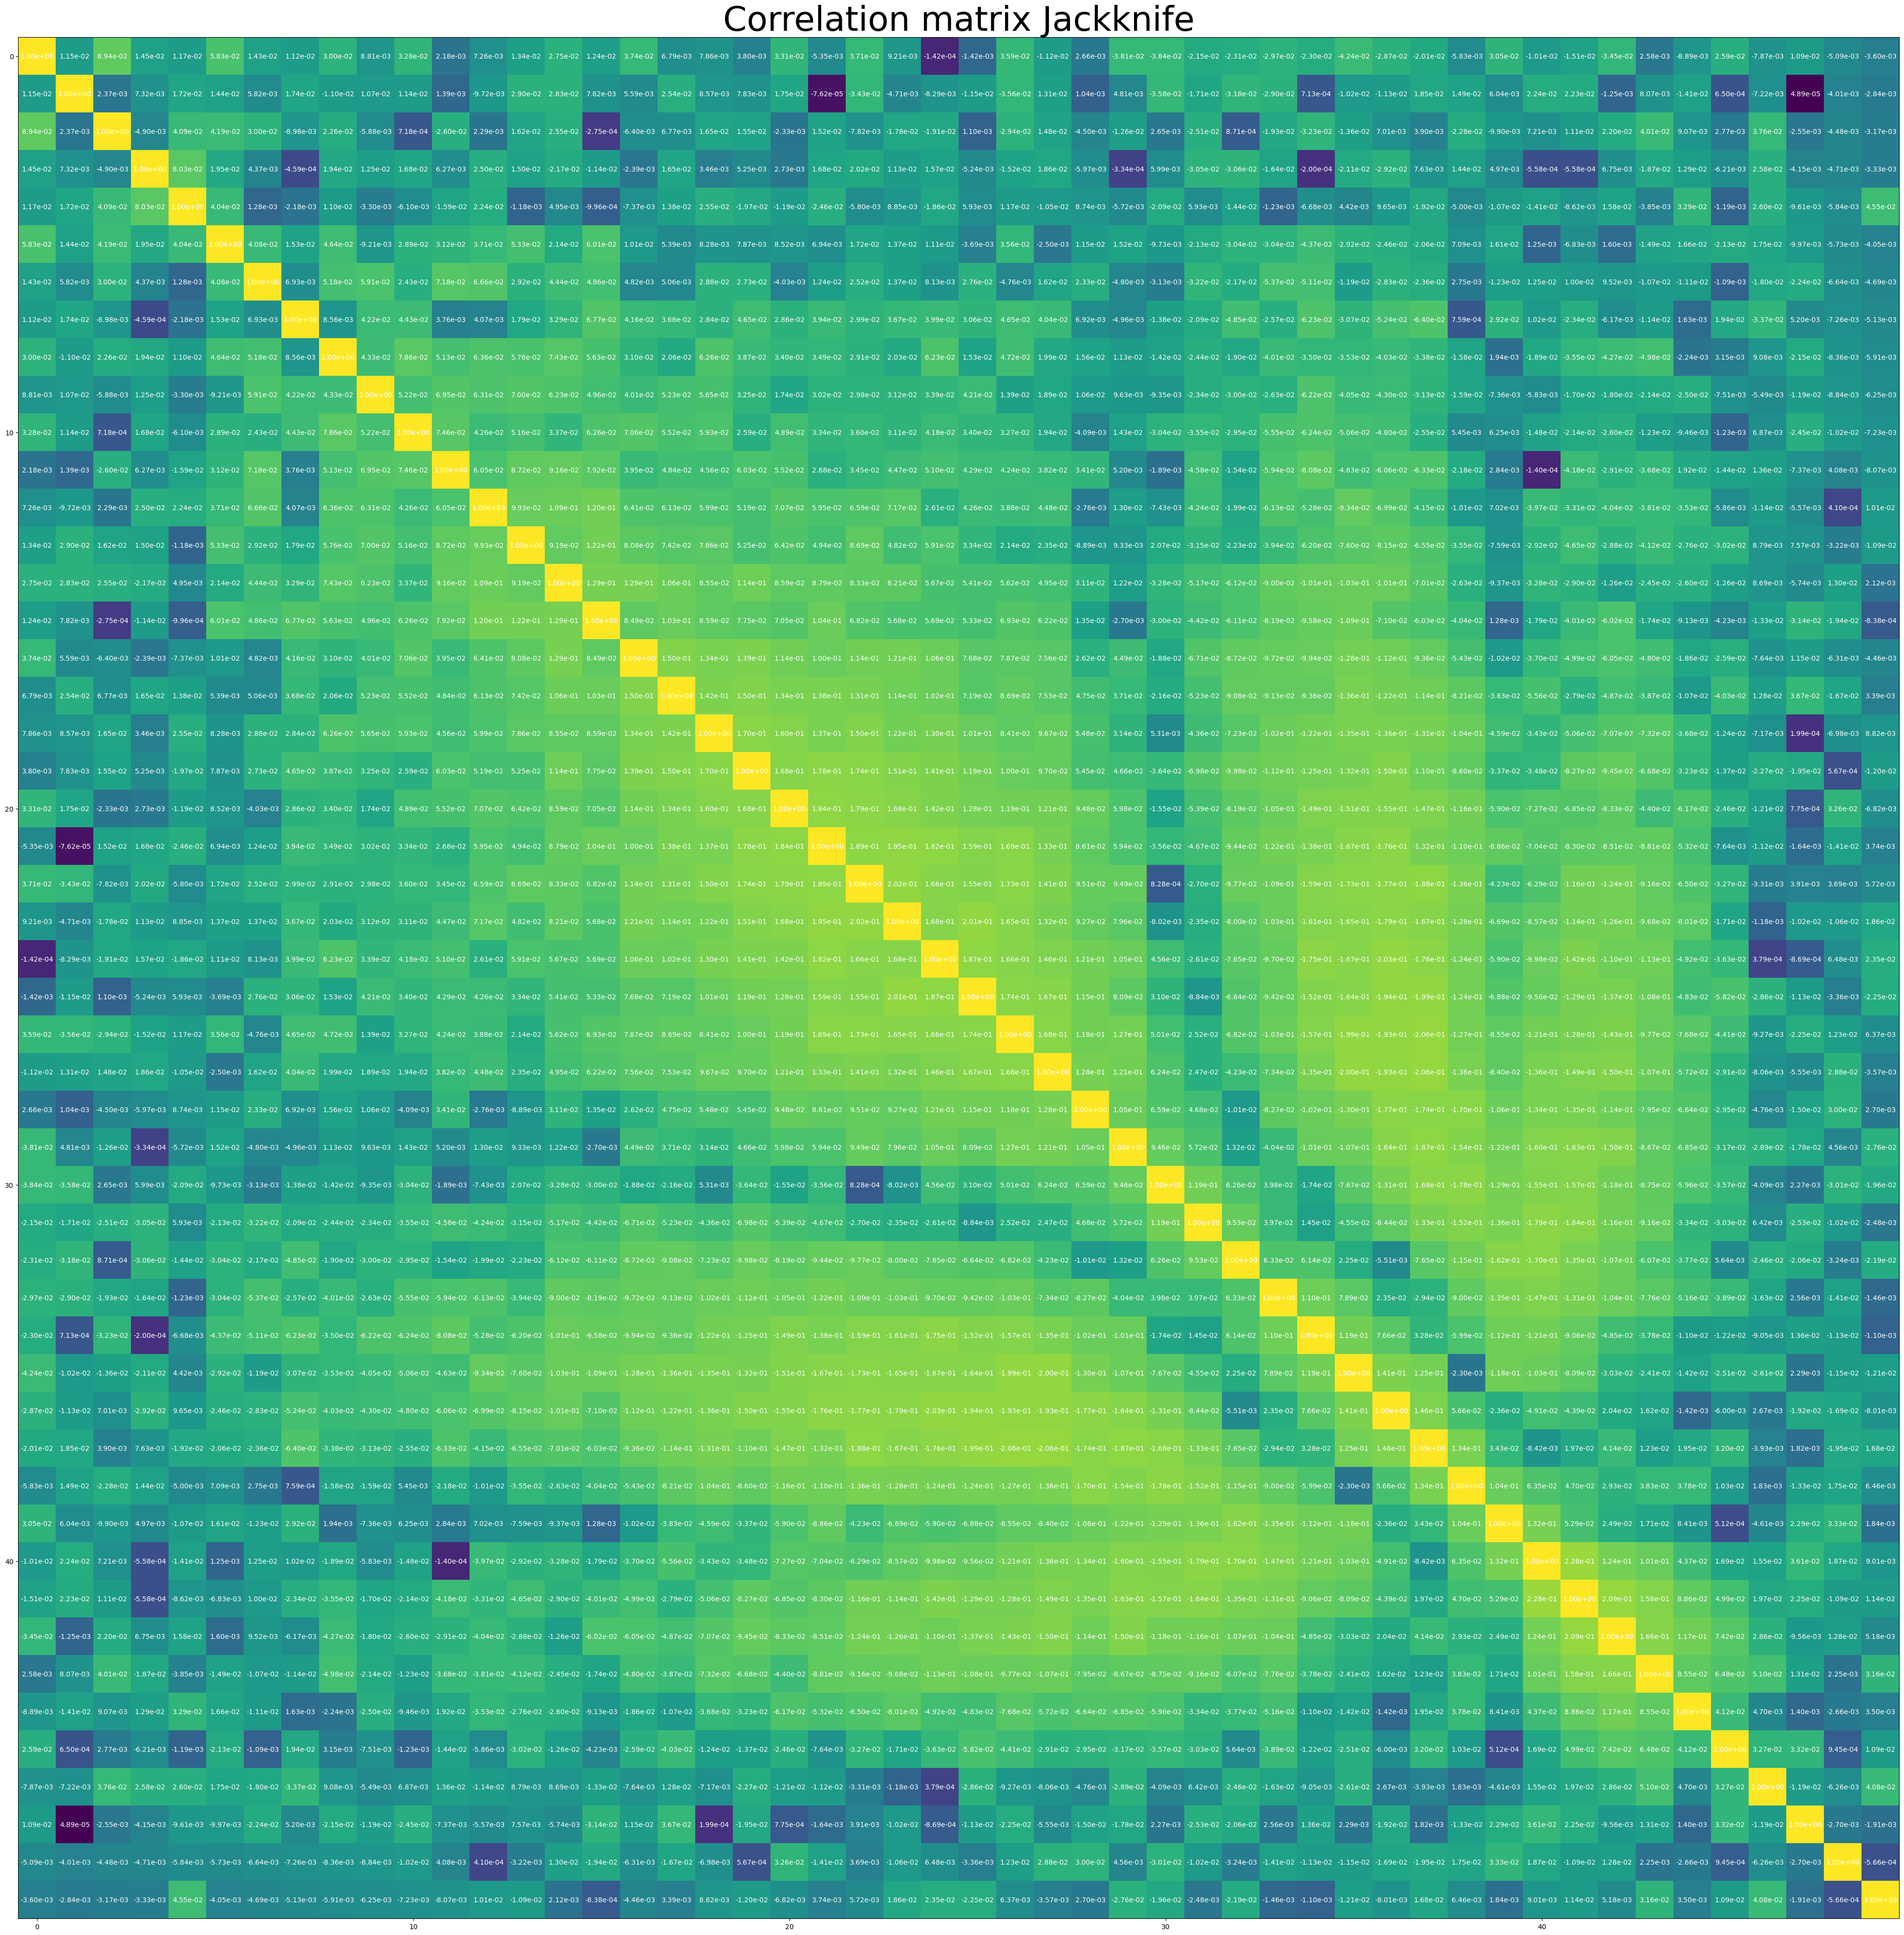

In [83]:
corr_jack=np.corrcoef(jack_matrix.T)

# Plotting the correlated
fig=plt.subplots(1,1,figsize=(50,50))
im = plt.imshow(np.log10((abs(corr_jack))))
#plt.xticks(np.arange(len(corr_jack)), labels=names)
#plt.yticks(np.arange(len(corr_jack)), labels=names)
plt.title('Correlation matrix Jackknife',fontsize=50)
for i in range(len(corr_jack)):
    for j in range(len(corr_jack)):
        text = plt.text(j, i, '{:.2e}'.format(corr_jack[i, j]),
                    ha="center", va="center", color="w")

<font color='red'>
When using a reasonable number of Jackknife subsets (like  5000), the Jackknife errors are close to the 'analytic' errors. The Jackknife errors are generally larger than the analytic errors. If we use too few Jackknife subsamples, the Jackknife errors are very big and overestimate the "true" errors. If we use too many Jackknife subsamples, we get small errors but the sample for each iteration of the Jackknife will basically be the same, the errors are artificially small. 

The bins are not independent since the off-diagonal terms are non-zero.

Now repeat this excercise, replacing the histogram with a calculation of the mean stellar mass as a function of redshift (i.e. split the data into redshift bins, and compute the mean mass in each).

Use Jackknife to get the errors. How do these compare with the standard error of the mean?

In [65]:
data_input=Table.read('../data/sw_input.fits')
redshifts=(data_input['redshift'].data)[cond_good]

In [66]:
bin_edges=[]
for i in range(11):
    bin_edges.append(np.quantile(redshifts,0.1*i))
bin_edges=np.array(bin_edges)

In [67]:
def separate(edges,x,y):
    xs=np.argsort(x)
    sort_x=x[xs]
    sort_y=y[xs]
    means=[]
    std=[]
    j1=0
    for i in range(len(edges)-1):
        check=np.where(sort_x<edges[i+1])[0]
        j2=check[-1]+1
        if i==(len(edges)-2):
            means.append(np.mean(sort_y[int(j1):]))
            std.append(np.std(sort_y[int(j1):],ddof=1))
        else:
            means.append(np.mean(sort_y[int(j1):int(j2)]))
            std.append(np.std(sort_y[int(j1):int(j2)],ddof=1))
        j1=j2
    means=np.array(means)
    #print(means)
    std=np.array(std)
    return means,std

array([0.00285854, 0.00192019, 0.00163867, 0.00147319, 0.00133508,
       0.00125914, 0.00122428, 0.00123613, 0.00137889, 0.00088287],
      dtype=float32)

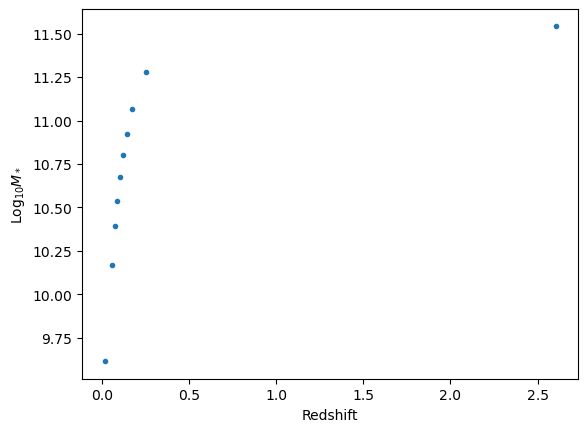

In [70]:
mean,std=separate(bin_edges,redshifts,mucho_stelmass)
center_bins=(bin_edges[1:]+bin_edges[:-1])/2

err=std/np.sqrt(len(redshifts)/10)


plt.errorbar(center_bins,mean,yerr=err,fmt='.')
plt.xlabel('Redshift')
plt.ylabel(r'Log$_{10}M_*$')
err

In [69]:
Njk=2000
all_ints=np.linspace(0,len(redshifts)-1,len(redshifts))
ints=np.array_split(all_ints,Njk)
#print(len(ints))
jack0=[]
for i in range(Njk):
    cond=(np.in1d(all_ints,ints[i])==0)
    a,b=separate(bin_edges,redshifts[cond],mucho_stelmass[cond])
    jack0.append(a)
jack0=np.array(jack0)

In [71]:
cov_jack0=np.cov(jack0.T)*(Njk-1)*(Njk-1)/Njk
diag_jack0=[]
for i in range(10):
    diag_jack0.append(np.sqrt(cov_jack0[i,i]))
cov_jack0

array([[2.54902997e-05, 3.38427554e-06, 3.15684314e-06, 3.29898344e-06,
        3.84757182e-06, 4.52552751e-06, 5.88553651e-06, 6.71456106e-06,
        1.10704913e-05, 4.92295036e-06],
       [3.38427554e-06, 9.50131631e-06, 3.21741599e-06, 3.57298060e-06,
        3.29292923e-06, 4.23722167e-06, 5.72655814e-06, 6.43085111e-06,
        9.84074378e-06, 3.96976441e-06],
       [3.15684314e-06, 3.21741599e-06, 7.32359999e-06, 3.19742374e-06,
        3.40702922e-06, 3.91957624e-06, 5.20875551e-06, 6.38065926e-06,
        1.05930914e-05, 4.98457666e-06],
       [3.29898344e-06, 3.57298060e-06, 3.19742374e-06, 7.36557983e-06,
        3.72780441e-06, 4.42426541e-06, 5.61392371e-06, 6.61194120e-06,
        1.01063818e-05, 4.37099757e-06],
       [3.84757182e-06, 3.29292923e-06, 3.40702922e-06, 3.72780441e-06,
        6.70744956e-06, 4.75739335e-06, 5.93831104e-06, 7.17587163e-06,
        1.14121262e-05, 4.76438755e-06],
       [4.52552751e-06, 4.23722167e-06, 3.91957624e-06, 4.42426541e-06,
   

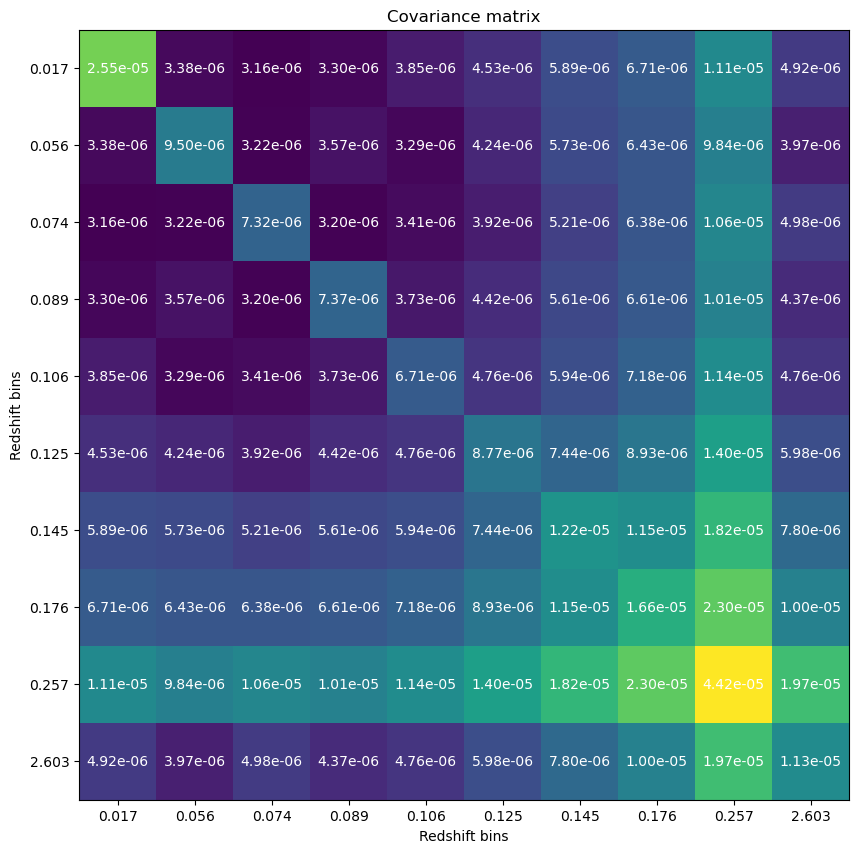

In [74]:
# Plotting the correlated
fig=plt.subplots(1,1,figsize=(10,10))
im = plt.imshow(np.log10((abs(cov_jack0))),vmin=np.min(np.log10(abs(cov_jack0))),vmax=np.max(np.log10(abs(cov_jack0))))
plt.xticks(np.arange(len(cov_jack0)), labels=np.round(center_bins,3))
plt.yticks(np.arange(len(cov_jack0)), labels=np.round(center_bins,3))
plt.xlabel('Redshift bins')
plt.ylabel('Redshift bins')
plt.title('Covariance matrix')
for i in range(len(cov_jack0)):
    for j in range(len(cov_jack0)):
        text = plt.text(j, i, '{:.2e}'.format(cov_jack0[i, j]),
                    ha="center", va="center", color="w")

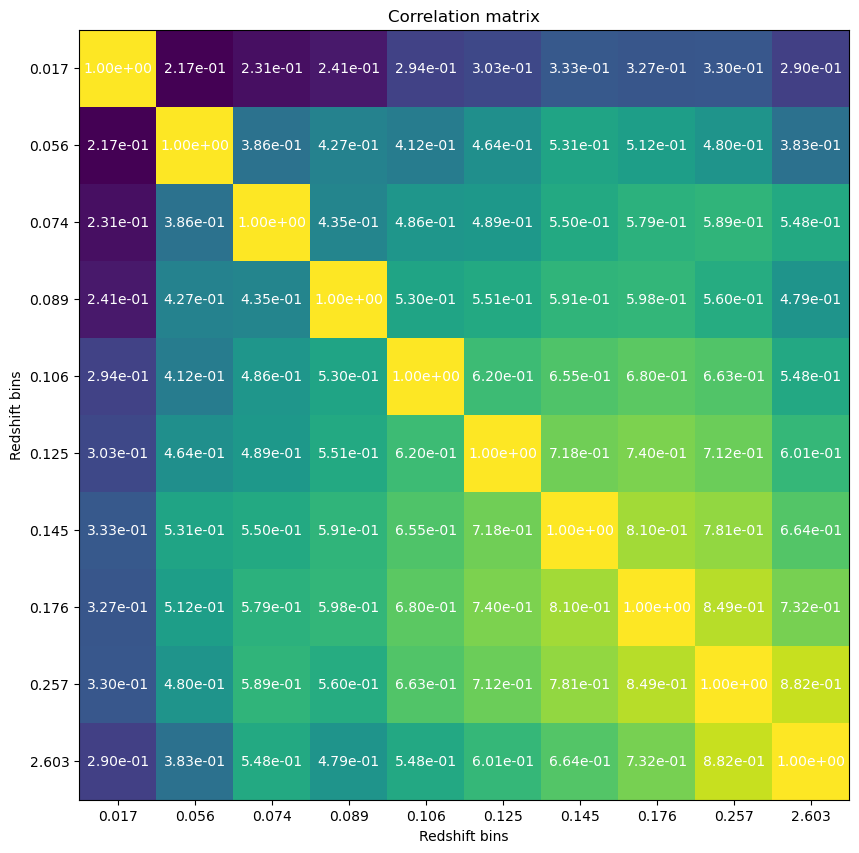

In [75]:
corr_jack0=np.corrcoef(jack0.T)

# Plotting the correlated
fig=plt.subplots(1,1,figsize=(10,10))
im = plt.imshow(np.log10((abs(corr_jack0))))
plt.xticks(np.arange(len(corr_jack0)), labels=np.round(center_bins,3))
plt.yticks(np.arange(len(corr_jack0)), labels=np.round(center_bins,3))
plt.xlabel('Redshift bins')
plt.ylabel('Redshift bins')
plt.title('Correlation matrix')
for i in range(len(corr_jack0)):
    for j in range(len(corr_jack0)):
        text = plt.text(j, i, '{:.2e}'.format(corr_jack0[i, j]),
                    ha="center", va="center", color="w")

In [76]:
for i in range(10):
    print(err[i],diag_jack0[i])

0.0028585421 0.005048791909427366
0.0019201875 0.0030824205278537605
0.0016386698 0.0027062150668816444
0.0014731883 0.002713960173909024
0.001335083 0.0025898744293910464
0.0012591418 0.0029607706924518386
0.0012242835 0.003499731895679113
0.0012361301 0.004072937668699023
0.0013788941 0.006651214154680033
0.0008828724 0.003359607344439809


Text(0, 0.5, 'Errors Log$_{10}M_*$')

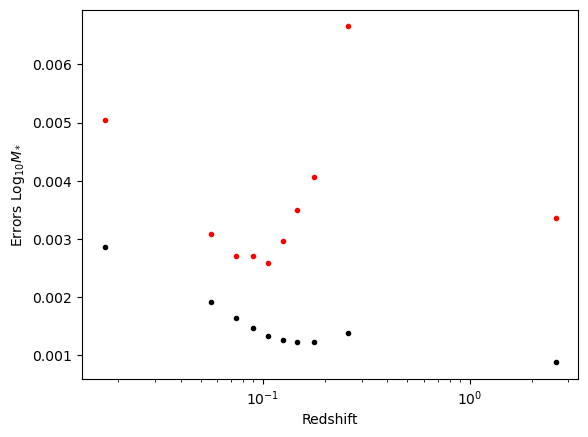

In [77]:
plt.errorbar(center_bins,err,fmt='.',color='black')
plt.errorbar(center_bins,diag_jack0,fmt='.',color='red')
plt.xscale('log')
plt.xlabel('Redshift')
plt.ylabel(r'Errors Log$_{10}M_*$')

<font color='red'>

The errors obtained with Jackknife are larger than the ones obtained from the standard uncertainty on the mean. 